Practicul Drought Indices
============


Introductie tekst m.b.t. exercise

In [1]:
import xarray as xr
import numpy as np
import scipy.stats as stats
import matplotlib
import matplotlib.pyplot as plt
#import gdal
#from osgeo import gdal, osr, ogr
import xlsxwriter
import pandas as pd

In [2]:
# Set up data sources

import os
os.chdir('G:/PhD/Teachings/Water Risks practicum/drought indices')
workingfolder = os.getcwd()
inputfolder   = os.path.join(workingfolder,'input') 

# Name input file
weather_file  = os.path.join(inputfolder,'Point_Data_Kenya.xlsx')
print(weather_file)

G:\PhD\Teachings\Water Risks practicum\drought indices\input\Point_Data_Kenya.xlsx


Exercise 1: Loading and inspecting input data
========
information
<br> 
more information

In [3]:
# Indicate the time for which data is available
data_start = 1971
data_end   = 2050
years = data_end - data_start  

hist_start = 1971
hist_end   = 2000
years_h = hist_end - hist_start  
h_in = (hist_start-data_start)*12
h_out= (hist_end-hist_start)*12

fut_start = 2001
fut_end   = 2050
years_f = fut_end - fut_start  
f_in = (hist_start - data_start)*12
f_out= (fut_end-fut_start)*12

In [4]:
df = pd.read_excel(weather_file, delimiter=',')

variables = {}   
variables['precipitation']      = df["Precipitation (mm)"].values
variables['evapotranspiration'] = df["Potential Evapotranspiration (mm)"].values
variables['runoff']             = df["Local_Runoff (mm)"].values
variables['discharge']          = df["Discharge (m3/sec)"].values
dates   = df["Date"]



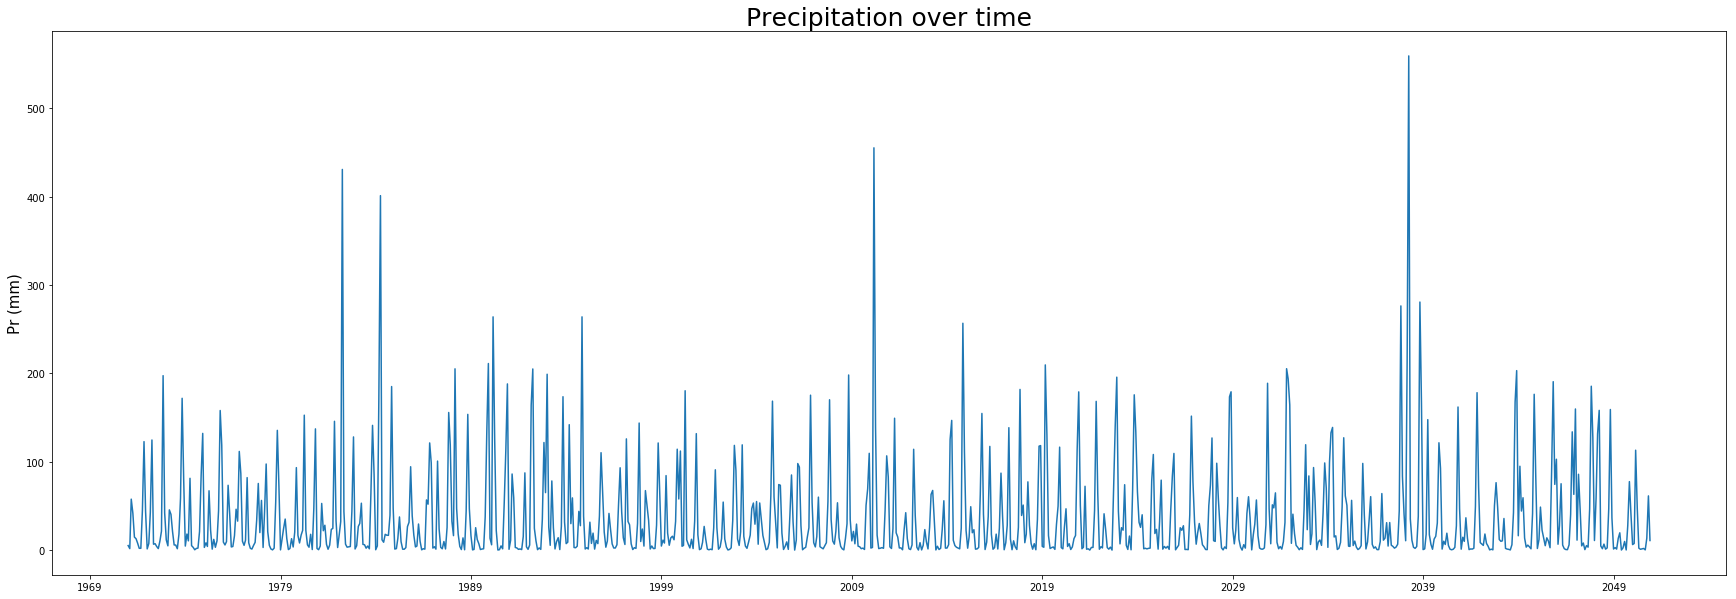

In [5]:
# Plot a time series to get familiar with the data
fig = plt.figure(figsize=(30,10) )
plt.plot(dates,variables['precipitation'])
plt.ylabel('Pr (mm)',size=15)
plt.title('Precipitation over time',size=25)
plt.show()

Exercise 2: SPI calculation for one month, for the historic period
========

1. Select monthly preciptiation values for the historic time period

In [6]:
# Extract historic values
hist_dataseries = variables['precipitation'][h_in:h_out]     

2. Prepare accumulated precipitation time series

In [7]:
# Choose accumulation time
accumulationtime = 6   
accumulatedvariables = {}

# Function to calculate accumulation of precipitation over months
accumulated_precipitation = np.cumsum(hist_dataseries, dtype=float)                 
accumulated_precipitation[accumulationtime:] = accumulated_precipitation[accumulationtime:] - accumulated_precipitation[:-accumulationtime]         
accumulated_precipitation[:accumulationtime - 1] = np.nan    

3. Select preciptiation values of a certain month

In [8]:
# choose a month
month = 3

In [9]:
# Extract values for that one month (but not the one from the first, incomplete year)
accumulated_precipitation_month = np.zeros(years_h-1)
for yr in range(1,int(years_h)):    
    accumulated_precipitation_month[yr-1] = accumulated_precipitation[(12*yr)+month]
print('precipitation values of one month:\n',accumulated_precipitation_month)

precipitation values of one month:
 [343.02694328 342.17446365 365.96784526 299.93783391 374.99562626
 307.29542156 295.37591412 281.59360271 310.64845164 219.18334605
 663.09243327 244.59545126 803.34665258 286.69072273 188.11390816
 328.37989935 576.17787654 243.60234876 754.40016195 459.68186075
 466.86990751 495.74383622 393.81269779 339.7303972  251.71800084
 315.04890385 299.74471898 292.38185456]


4. Calculate the historic SPI for that month

In [10]:
# Find distribution parameters of Gamma function      
dist = getattr(stats, 'gamma')
param = dist.fit(accumulated_precipitation_month)
rv = dist(*param)    

In [11]:
# Assess goodness-of-fit using Kolmogorov–Smirnov test
D, p = stats.kstest(accumulated_precipitation_month, 'gamma', args=param)                    
print('pvalue: ',p)

pvalue:  0.5962122470343483


In [12]:
# Solve issue with zero values in Gamma distribution (cfr.Stagge et al. 2015)  
nyears_zero = len(accumulated_precipitation_month) - np.count_nonzero(accumulated_precipitation_month)
p_zero = nyears_zero / len(accumulated_precipitation_month)
p_zero_mean = (nyears_zero + 1) / (2 * (len(accumulated_precipitation_month) + 1))           
ppd = (accumulated_precipitation_month * 0 ) + p_zero_mean
ppd[np.nonzero(accumulated_precipitation_month)] = p_zero+((1-p_zero)*rv.cdf(accumulated_precipitation_month[np.nonzero(accumulated_precipitation_month)]))

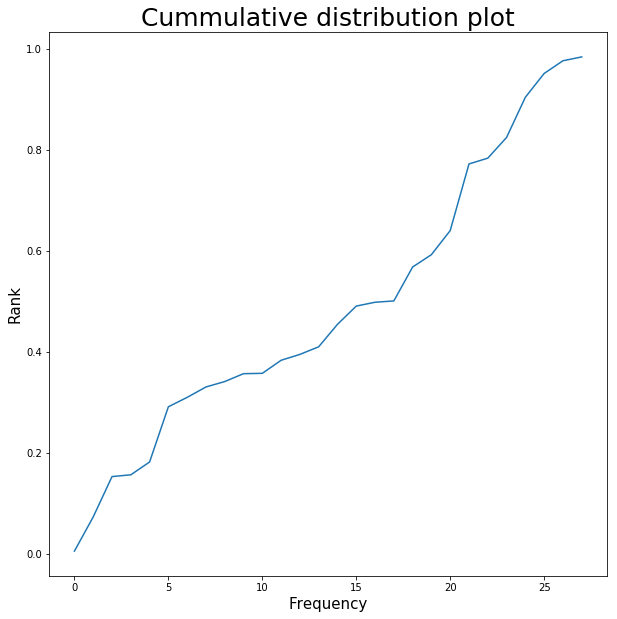

In [13]:
#Plot cummulative distribution function
fig = plt.figure(figsize=(10,10) )
plt.plot(np.sort(ppd))
plt.ylabel('Rank',size=15)
plt.xlabel('Frequency',size=15)
plt.title('Cummulative distribution plot',size=25)
plt.show()   

In [14]:
# Standardize the fitted cummulative distribtuion distribution  
z_month = stats.norm.ppf(ppd)                                   
z_month[z_month>3] = 3
z_month[z_month<-3] = -3 
print('SPI values of one month:\n',z_month)

SPI values of one month:
 [ 0.00362854 -0.00295304  0.17269849 -0.36352674  0.23541181 -0.29509072
 -0.40741954 -0.54776951 -0.26479972 -1.44730763  1.66177472 -1.00598835
  2.15752853 -0.4944109  -2.50020714 -0.11285283  1.30831376 -1.02061846
  1.99306057  0.74746769  0.78598982  0.9347829   0.36020064 -0.02195236
 -0.90549548 -0.22584155 -0.36536132 -0.43688086]


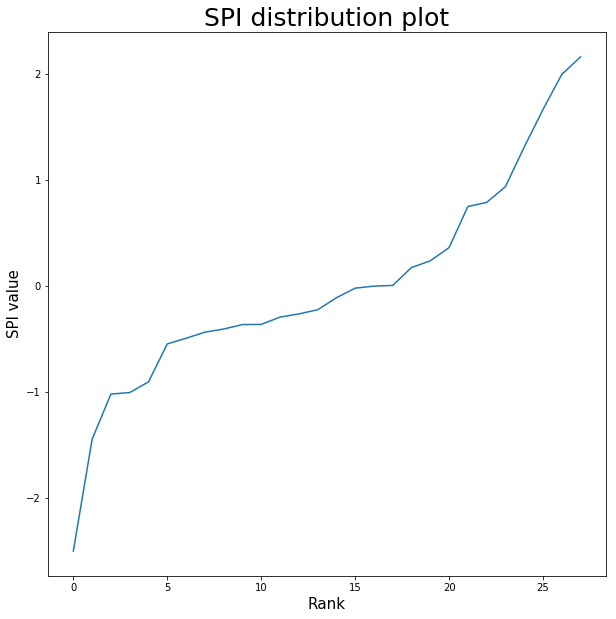

In [15]:
#Plot SPI function
fig = plt.figure(figsize=(10,10) )
plt.plot(np.sort(z_month))
plt.ylabel('SPI value',size=15)
plt.xlabel('Rank',size=15)
plt.title('SPI distribution plot',size=25)
plt.show()  

4. Reconstruct the full time series

In [16]:
# Bring the SPI values back in their right spot in the historic time series
indexvalues_month = hist_dataseries * np.nan
for yr in range(1,years_h):
    indexvalues_month[(12*yr)+month] = z_month[yr-1]

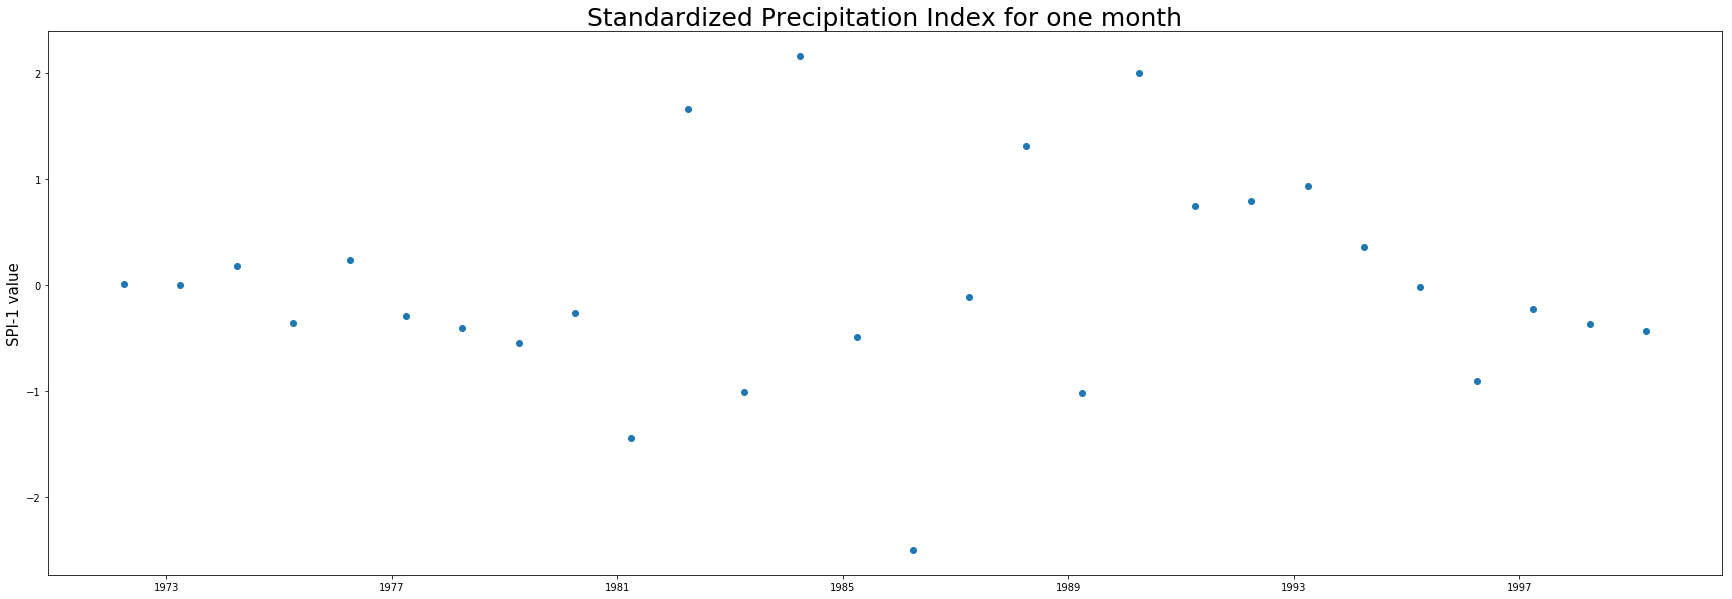

In [17]:
#Plot the calculated SPI values over time
fig = plt.figure(figsize=(30,10) )
plt.plot(dates[h_in:h_out],indexvalues_month,"o")
plt.ylabel('SPI-1 value',size=15)
plt.title('Standardized Precipitation Index for one month',size=25)
plt.show()

Exercise 3: SPI-1 calculation for each month over the historic time-period 
==========

In [18]:
# Extract historic data
hist_dataseries = variables['precipitation'][h_in:h_out]     

In [19]:
SPI1 = np.zeros(hist_dataseries.shape)

In [20]:
# loop over all months to calculate SPI per month
for m in range(12):
    
    # Extract values per month, ignore first, incomplete year
    values = np.zeros(years_h-1)
    for yr in range(1,years_h):     
        values[yr-1] = hist_dataseries[(12*yr)+m]

    # Find distribution parameters of Gamma function      
    dist = getattr(stats, 'gamma')
    param = dist.fit(values)
    rv = dist(*param)   
    
    # Solve issue with zero values in Gamma distribution (cfr.Stagge et al. 2015)  
    nyears_zero = len(values) - np.count_nonzero(values)
    p_zero = nyears_zero / len(values)
    p_zero_mean = (nyears_zero + 1) / (2 * (len(values) + 1))           
    ppd = (values * 0 ) + p_zero_mean
    ppd[np.nonzero(values)] = p_zero+((1-p_zero)*rv.cdf(values[np.nonzero(values)]))
    
    # Standardize the cummulative distribution function
    z = stats.norm.ppf(ppd)                                   
    z[z>3] = 3
    z[z<-3] = -3 
    
    # Bring the SPI values back in their right spot in the time series
    for yr in range(1,years_h):
        SPI1[(12*yr)+m] = z[yr-1]      

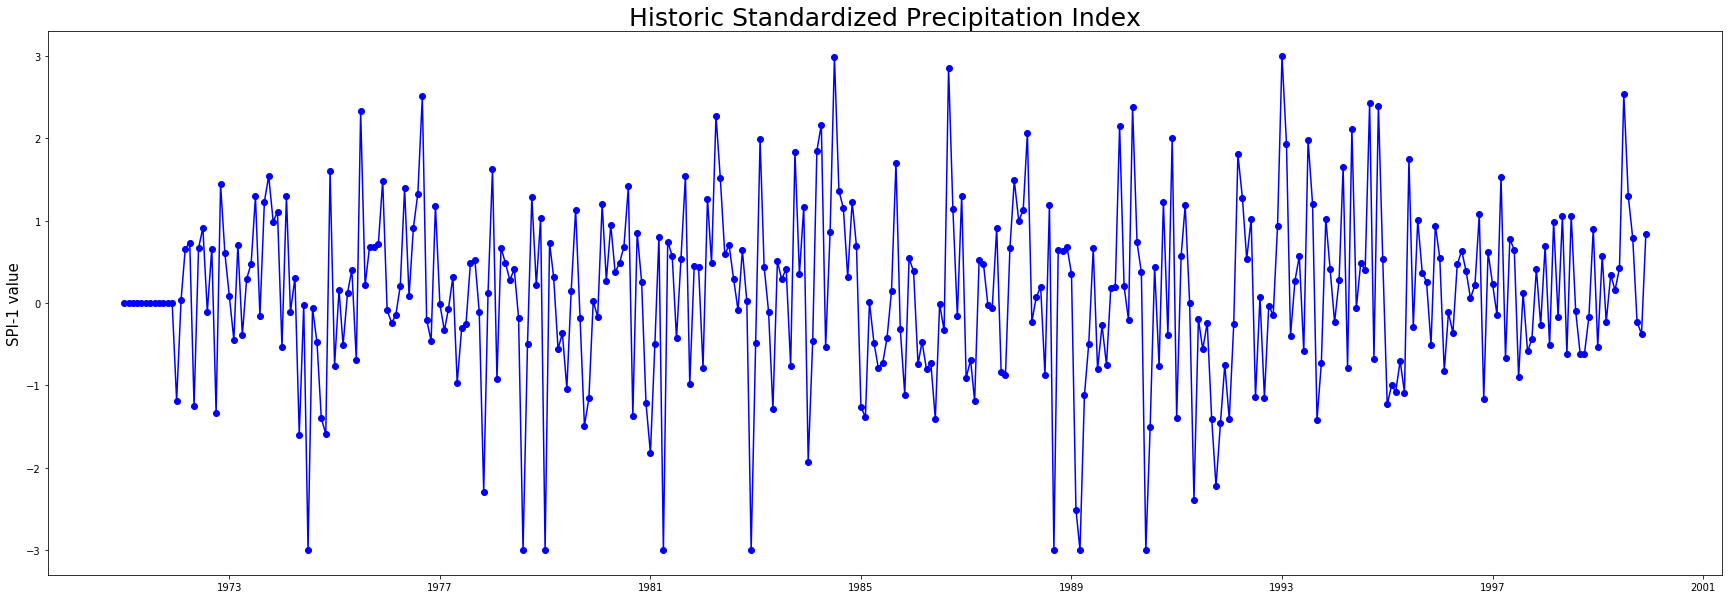

In [21]:
#Plot the calculated SPI values over time
fig = plt.figure(figsize=(30,10) )
plt.plot(dates[h_in:h_out],SPI1,"-o",color='b')
plt.ylabel('SPI-1 value',size=15)
plt.title('Historic Standardized Precipitation Index',size=25)
plt.show()

Exercise 3: SPI-3 calculation for each month over the historic time-period 
==========

In [22]:
# Extract historic data
hist_dataseries = variables['precipitation'][h_in:h_out]    

In [23]:
SPI3 = np.zeros(hist_dataseries.shape)

In [24]:
# Create accumulated data
accumulationtime = 3   
cummuldata = np.cumsum(hist_dataseries, dtype=float)                 
cummuldata[accumulationtime:] = cummuldata[accumulationtime:] - cummuldata[:-accumulationtime]         
cummuldata[:accumulationtime - 1] = np.nan                                           
cummul_hist_dataseries = cummuldata  

In [25]:
# loop over all months to calculate SPI per month
for m in range(12):
    
    # Extract values per month, ignore first, incomplete year
    values = np.zeros(years_h-1)
    for yr in range(1,years_h):     
        values[yr-1] = cummul_hist_dataseries[(12*yr)+m]

    # Find distribution parameters of Gamma function      
    dist = getattr(stats, 'gamma')
    param = dist.fit(values)
    rv = dist(*param)   
    
    # Solve issue with zero values in Gamma distribution (cfr.Stagge et al. 2015)  
    nyears_zero = len(values) - np.count_nonzero(values)
    p_zero = nyears_zero / len(values)
    p_zero_mean = (nyears_zero + 1) / (2 * (len(values) + 1))           
    ppd = (values * 0 ) + p_zero_mean
    ppd[np.nonzero(values)] = p_zero+((1-p_zero)*rv.cdf(values[np.nonzero(values)]))
    
    # Standardize the cummulative distribution function
    z = stats.norm.ppf(ppd)                                   
    z[z>3] = 3
    z[z<-3] = -3 
    
    # Bring the SPI values back in their right spot in the time series
    for yr in range(1,years_h):
        SPI3[(12*yr)+m] = z[yr-1]   

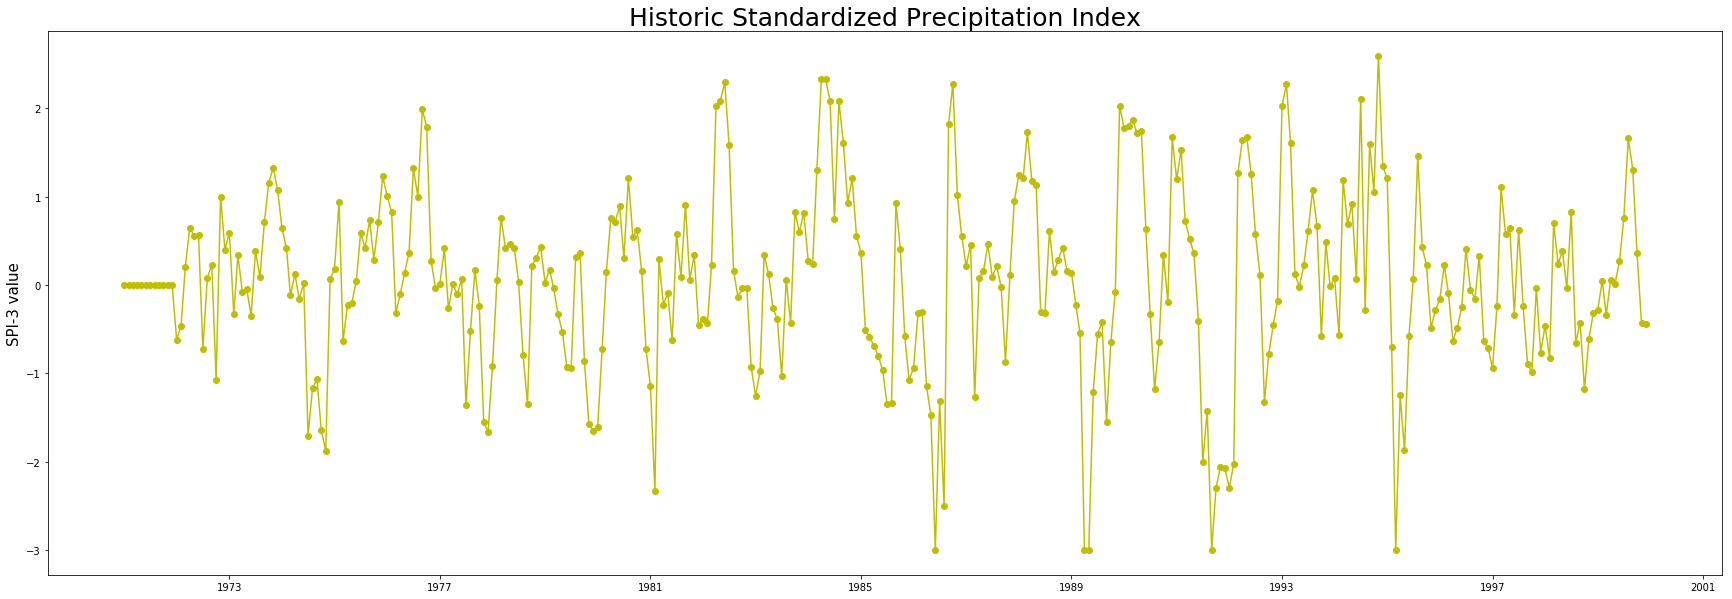

In [26]:
#Plot the calculated SPI values over time
fig = plt.figure(figsize=(30,10) )
plt.plot(dates[h_in:h_out],SPI3,"-o",color='y')
plt.ylabel('SPI-3 value',size=15)
plt.title('Historic Standardized Precipitation Index',size=25)
plt.show()

Exercise 4: SPI-6 calculation for each month over the historic time-period 
==========

In [27]:
# Extract historic data
hist_dataseries = variables['precipitation'][h_in:h_out]    

In [28]:
SPI6 = np.zeros(hist_dataseries.shape)

In [29]:
# Create accumulated data
accumulationtime = 6   
cummuldata = np.cumsum(hist_dataseries, dtype=float)                 
cummuldata[accumulationtime:] = cummuldata[accumulationtime:] - cummuldata[:-accumulationtime]         
cummuldata[:accumulationtime - 1] = np.nan                                           
cummul_hist_dataseries = cummuldata  

In [30]:
# loop over all months to calculate SPI per month
for m in range(12):
    
    # Extract values per month, ignore first, incomplete year
    values = np.zeros(years_h-1)
    for yr in range(1,years_h):     
        values[yr-1] = cummul_hist_dataseries[(12*yr)+m]

    # Find distribution parameters of Gamma function      
    dist = getattr(stats, 'gamma')
    param = dist.fit(values)
    rv = dist(*param)   
    
    # Solve issue with zero values in Gamma distribution (cfr.Stagge et al. 2015)  
    nyears_zero = len(values) - np.count_nonzero(values)
    p_zero = nyears_zero / len(values)
    p_zero_mean = (nyears_zero + 1) / (2 * (len(values) + 1))           
    ppd = (values * 0 ) + p_zero_mean
    ppd[np.nonzero(values)] = p_zero+((1-p_zero)*rv.cdf(values[np.nonzero(values)]))
    
    # Standardize the cummulative distribution function
    z = stats.norm.ppf(ppd)                                   
    z[z>3] = 3
    z[z<-3] = -3 
    
    # Bring the SPI values back in their right spot in the time series
    for yr in range(1,years_h):
        SPI6[(12*yr)+m] = z[yr-1]   

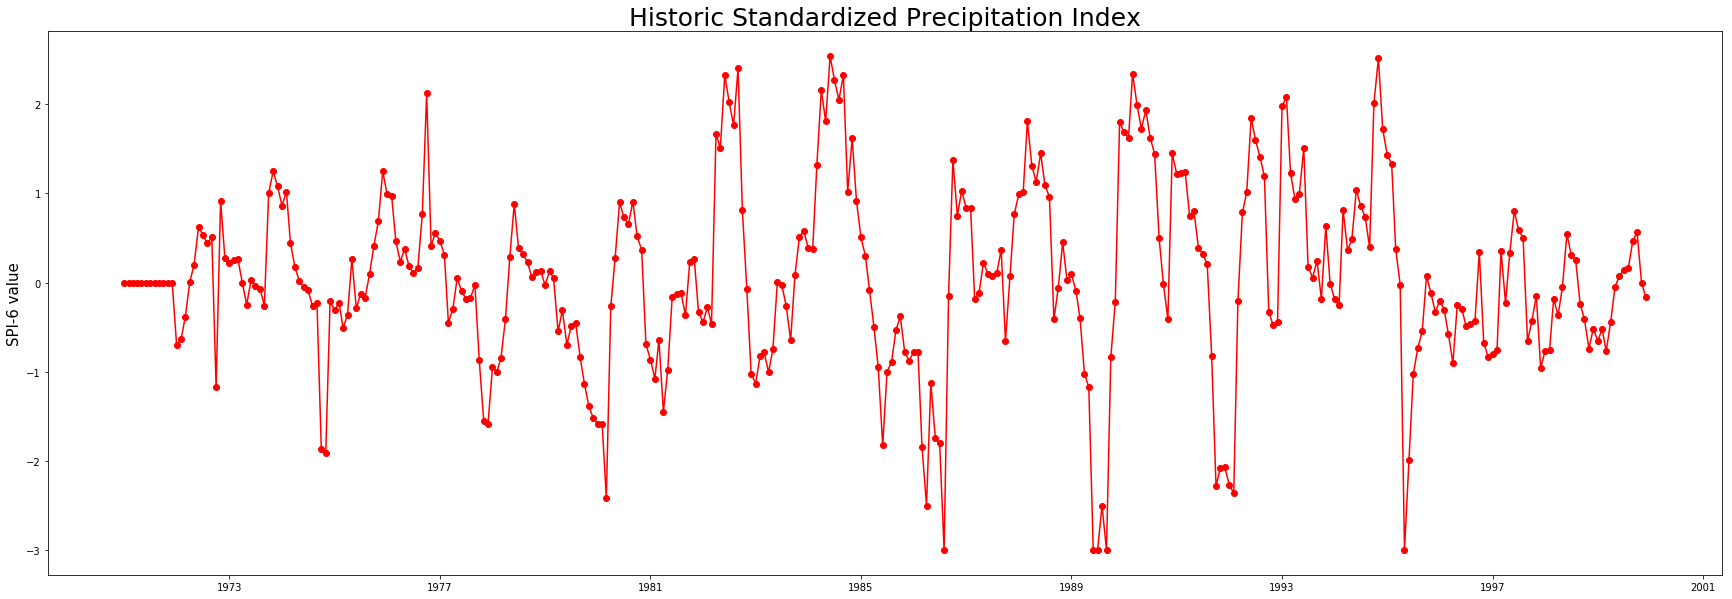

In [31]:
#Plot the calculated SPI values over time
fig = plt.figure(figsize=(30,10) )
plt.plot(dates[h_in:h_out],SPI6,"-o",color='r')
plt.ylabel('SPI-6 value',size=15)
plt.title('Historic Standardized Precipitation Index',size=25)
plt.show()

Exercise 5: Evaluate historic meteorological drought conditions 
==========

In [32]:
# Define drought threshold over which droughts are being identified
threshold = -1 
thresholds = SPI1 * 0 + threshold

In [33]:
# Identify droughts
dSPI1 = np.zeros(SPI1.shape)
dSPI1[SPI1<-1] = 1
dSPI3 = np.zeros(SPI3.shape)
dSPI3[SPI3<-1] = 1
dSPI6 = np.zeros(SPI1.shape)
dSPI6[SPI6<-1] = 1

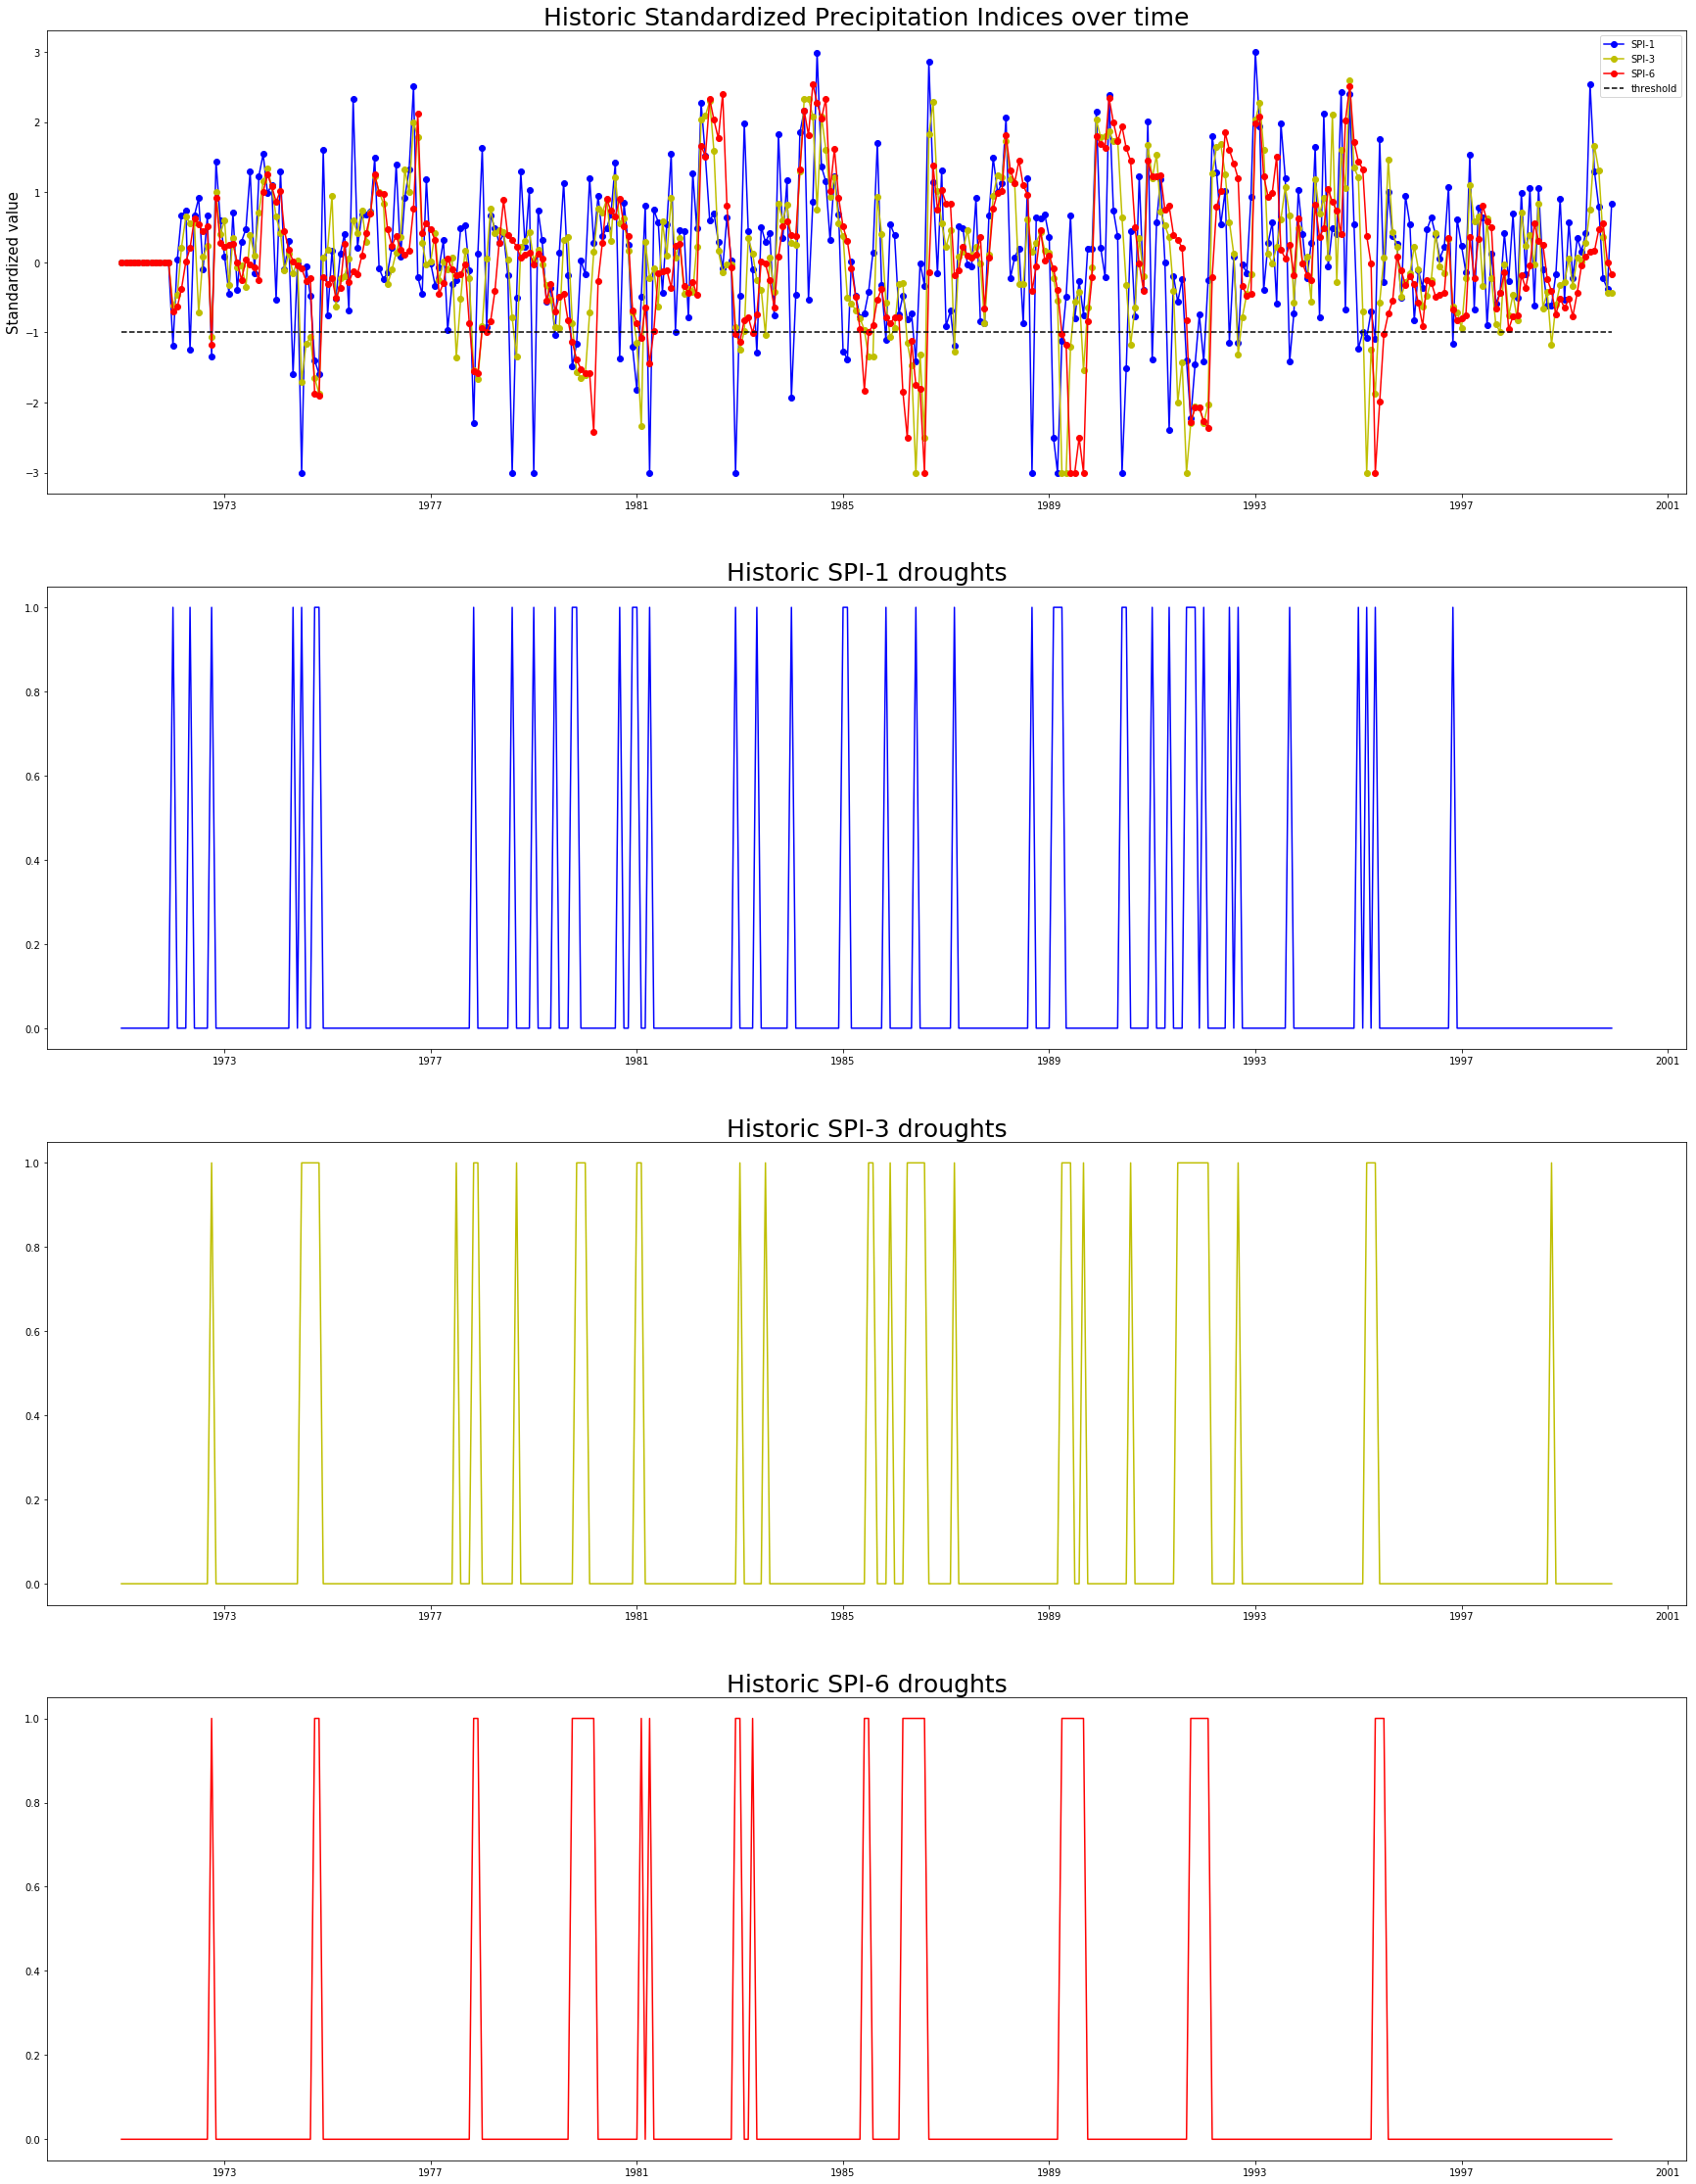

In [34]:
# Plot time-series of SPI values and drought conditions
fig = plt.figure(figsize=(30,40) )

plt.subplot(4, 1, 1)
l1=plt.plot(dates[h_in:h_out],SPI1,"-o", color='b',label='SPI-1')
l2=plt.plot(dates[h_in:h_out],SPI3,"-o", color='y',label='SPI-3')
l3=plt.plot(dates[h_in:h_out],SPI6,"-o", color='r',label='SPI-6')
l4=plt.plot(dates[h_in:h_out],thresholds,"--", color='k',label='threshold')
plt.ylabel('Standardized value',size=15)
plt.title('Historic Standardized Precipitation Indices over time',size=25)
plt.legend()#(l1,l2,l3,l4), ('SPI-1', 'SPI-3', 'SPI-6','drought threshold'),'upper left')

plt.subplot(4, 1, 2)
plt.plot(dates[h_in:h_out],dSPI1, color='b')
plt.title('Historic SPI-1 droughts',size=25)

plt.subplot(4, 1, 3)
plt.plot(dates[h_in:h_out],dSPI3, color='y')

plt.title('Historic SPI-3 droughts',size=25)
plt.subplot(4, 1, 4)

plt.plot(dates[h_in:h_out],dSPI6, color='r')
plt.title('Historic SPI-6 droughts',size=25)


plt.show()

In [35]:
# Analyse the total number of drought months
print('number of months under SPI-1 drought conditions: ',np.sum(dSPI1))
print('number of months under SPI-3 drought conditions: ',np.sum(dSPI3))
print('number of months under SPI-6 drought conditions: ',np.sum(dSPI6))

number of months under SPI-1 drought conditions:  44.0
number of months under SPI-3 drought conditions:  44.0
number of months under SPI-6 drought conditions:  38.0


In [36]:
# analyse the propagation of droughts over time to evaluate drought duration
SPI1propagation = SPI1 * 0
for t in range(len(SPI1)):
    if SPI1[t] <= threshold:
        SPI1propagation[t] = SPI1propagation[t-1] + 1
        SPI1propagation[t-1] = 0
    else:
        SPI1propagation[t] = 0
print('average duration SPI-1 drought conditions: ',np.mean(SPI1propagation[SPI1propagation>0]),' months')

SPI3propagation = SPI3 * 0
for t in range(len(SPI3)):
    if SPI3[t] <= threshold:
        SPI3propagation[t] = SPI3propagation[t-1] + 1
        SPI3propagation[t-1] = 0
    else:
        SPI3propagation[t] = 0
print('average duration SPI-3 drought conditions: ',np.mean(SPI3propagation[SPI3propagation>0]),' months')

SPI6propagation = SPI6 * 0
for t in range(len(SPI6)):
    if SPI6[t] <= threshold:
        SPI6propagation[t] = SPI6propagation[t-1] + 1
        SPI6propagation[t-1] = 0
    else:
        SPI6propagation[t] = 0
print('average duration SPI-6 drought conditions: ',np.mean(SPI6propagation[SPI6propagation>0]),' months')


average duration SPI-1 drought conditions:  1.2571428571428571  months
average duration SPI-3 drought conditions:  2.2  months
average duration SPI-6 drought conditions:  2.923076923076923  months


In [37]:
# Analyse the total number of drought events
SPI1propagation[SPI1propagation>0] = 1
print('number of SPI-1 droughts: ',np.sum(SPI1propagation))
SPI3propagation[SPI3propagation>0] = 1
print('number of SPI-3 droughts: ',np.sum(SPI3propagation))
SPI6propagation[SPI6propagation>0] = 1
print('number of SPI-6 droughts: ',np.sum(SPI6propagation))

number of SPI-1 droughts:  35.0
number of SPI-3 droughts:  20.0
number of SPI-6 droughts:  13.0


Exercise 6: SPEI-1 calculation for each month over the historic time-period 
==========

In [38]:
# Extract historic precipitation minus evapotranspiration data
hist_dataseries = variables['precipitation'][h_in:h_out] - variables['evapotranspiration'][h_in:h_out]   

In [39]:
SPEI1 = np.zeros(hist_dataseries.shape)

In [40]:
# loop over all months to calculate SPI per month
for m in range(12):
    
    # Extract values per month, ignore first, incomplete year
    values = np.zeros(years_h-1)
    for yr in range(1,years_h):     
        values[yr-1] = hist_dataseries[(12*yr)+m]

    # Find distribution parameters of Gamma function      
    dist = getattr(stats, 'genextreme')
    param = dist.fit(values)
    rv = dist(*param)   
    
    # Standardize the cummulative distribution function
    z = stats.norm.ppf(ppd)                                   
    z[z>3] = 3
    z[z<-3] = -3 
    
    # Bring the SPI values back in their right spot in the time series
    for yr in range(1,years_h):
        SPEI1[(12*yr)+m] = z[yr-1]      

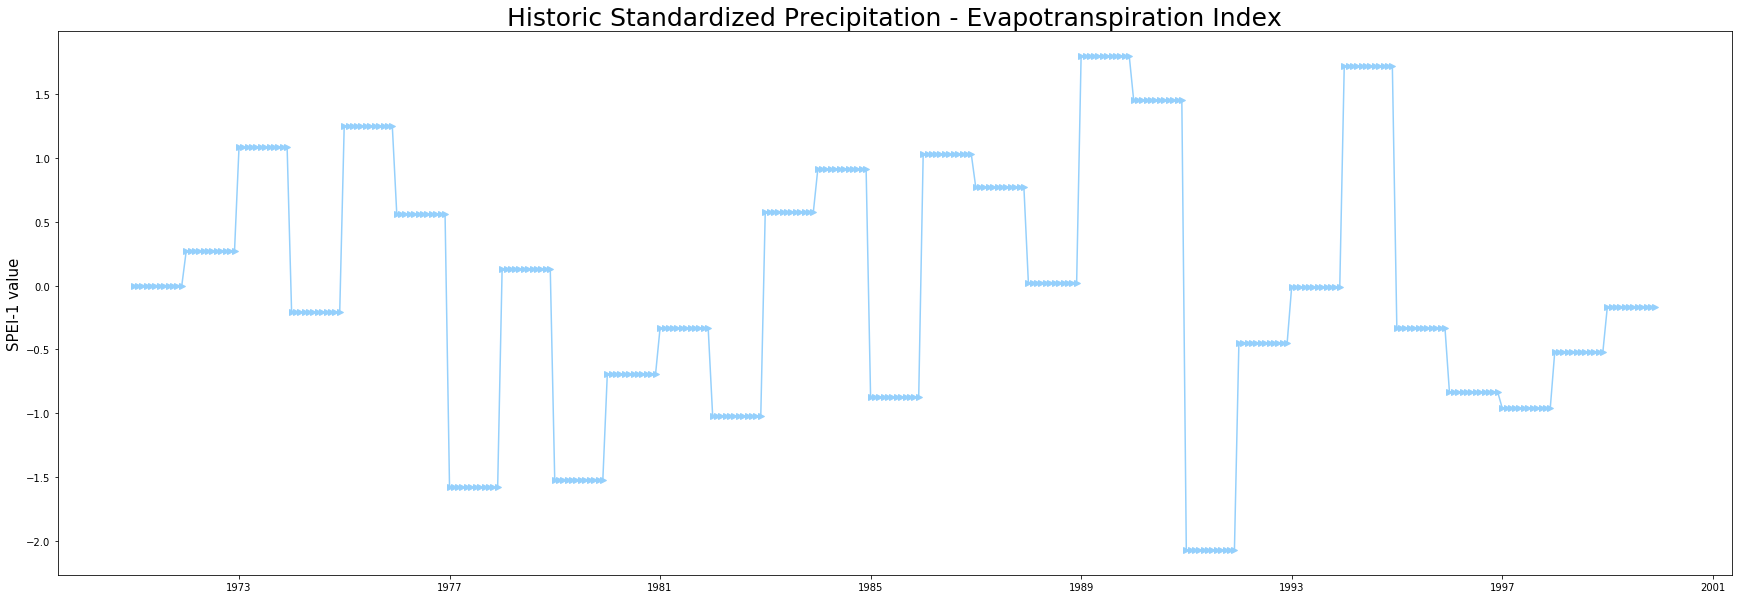

In [41]:
#Plot the calculated SPEI values over time
fig = plt.figure(figsize=(30,10) )
plt.plot(dates[h_in:h_out],SPEI1,"->",color='#95d0fc')
plt.ylabel('SPEI-1 value',size=15)
plt.title('Historic Standardized Precipitation - Evapotranspiration Index',size=25)
plt.show()

Exercise 7: SPEI-3 calculation for each month over the historic time-period 
==========

In [42]:
# Extract historic data, leave out first year (incomplete)
hist_dataseries = variables['precipitation'][h_in:h_out]  - variables['evapotranspiration'][h_in:h_out]    

In [43]:
SPEI3 = np.zeros(hist_dataseries.shape)

In [44]:
# Create accumulated data
accumulationtime = 3   
cummuldata = np.cumsum(hist_dataseries, dtype=float)                 
cummuldata[accumulationtime:] = cummuldata[accumulationtime:] - cummuldata[:-accumulationtime]         
cummuldata[:accumulationtime - 1] = np.nan                                           
cummul_hist_dataseries = cummuldata  

In [45]:
# loop over all months to calculate SPI per month
for m in range(12):
    
    # Extract values per month, ignore first, incomplete year
    values = np.zeros(years_h-1)
    for yr in range(1,years_h):     
        values[yr-1] = cummul_hist_dataseries[(12*yr)+m]

    # Find distribution parameters of Gamma function      
    dist = getattr(stats, 'genextreme')
    param = dist.fit(values)
    rv = dist(*param)   
    
    # Standardize the cummulative distribution function
    z = stats.norm.ppf(ppd)                                   
    z[z>3] = 3
    z[z<-3] = -3 
    
    # Bring the SPI values back in their right spot in the time series
    for yr in range(1,years_h):
        SPEI3[(12*yr)+m] = z[yr-1]   

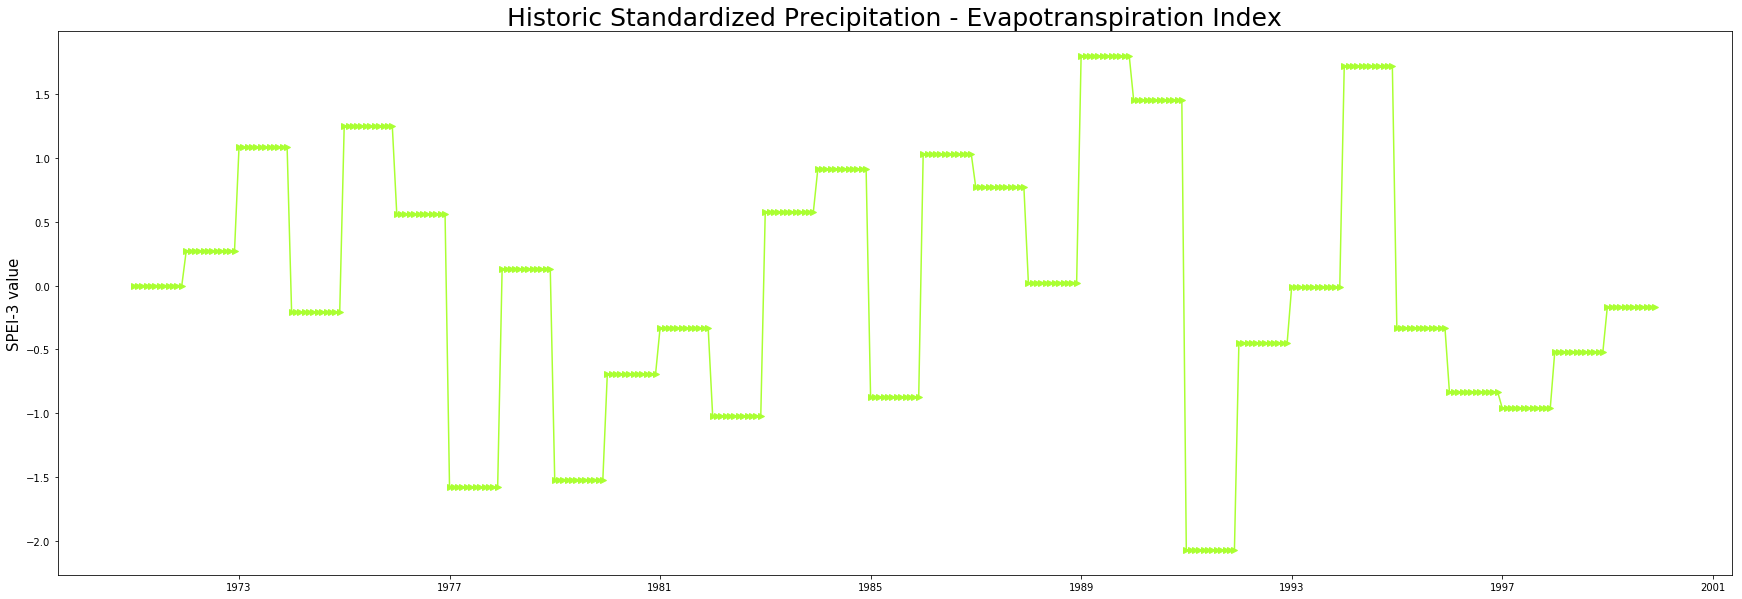

In [46]:
#Plot the calculated SPI values over time
fig = plt.figure(figsize=(30,10) )
plt.plot(dates[h_in:h_out],SPEI3,"->",color='#aaff32')
plt.ylabel('SPEI-3 value',size=15)
plt.title('Historic Standardized Precipitation - Evapotranspiration Index',size=25)
plt.show()

Exercise 8: SPEI-6 calculations for each month over the historic time-period 
==========

In [47]:
# Extract historic data, leave out first year (incomplete)
hist_dataseries = variables['precipitation'][h_in:h_out]- variables['evapotranspiration'][h_in:h_out]      

In [48]:
SPEI6 = np.zeros(hist_dataseries.shape)

In [49]:
# Create accumulated data
accumulationtime = 6   
cummuldata = np.cumsum(hist_dataseries, dtype=float)                 
cummuldata[accumulationtime:] = cummuldata[accumulationtime:] - cummuldata[:-accumulationtime]         
cummuldata[:accumulationtime - 1] = np.nan                                           
cummul_hist_dataseries = cummuldata  

In [50]:
# loop over all months to calculate SPI per month
for m in range(12):
    
    # Extract values per month, ignore first, incomplete year
    values = np.zeros(years_h-1)
    for yr in range(1,years_h):     
        values[yr-1] = cummul_hist_dataseries[(12*yr)+m]

    # Find distribution parameters of Gamma function      
    dist = getattr(stats, 'gamma')
    param = dist.fit(values)
    rv = dist(*param)   
    
    # Solve issue with zero values in Gamma distribution (cfr.Stagge et al. 2015)  
    nyears_zero = len(values) - np.count_nonzero(values)
    p_zero = nyears_zero / len(values)
    p_zero_mean = (nyears_zero + 1) / (2 * (len(values) + 1))           
    ppd = (values * 0 ) + p_zero_mean
    ppd[np.nonzero(values)] = p_zero+((1-p_zero)*rv.cdf(values[np.nonzero(values)]))
    
    # Standardize the cummulative distribution function
    z = stats.norm.ppf(ppd)                                   
    z[z>3] = 3
    z[z<-3] = -3 
    
    # Bring the SPI values back in their right spot in the time series
    for yr in range(1,years_h):
        SPEI6[(12*yr)+m] = z[yr-1]   

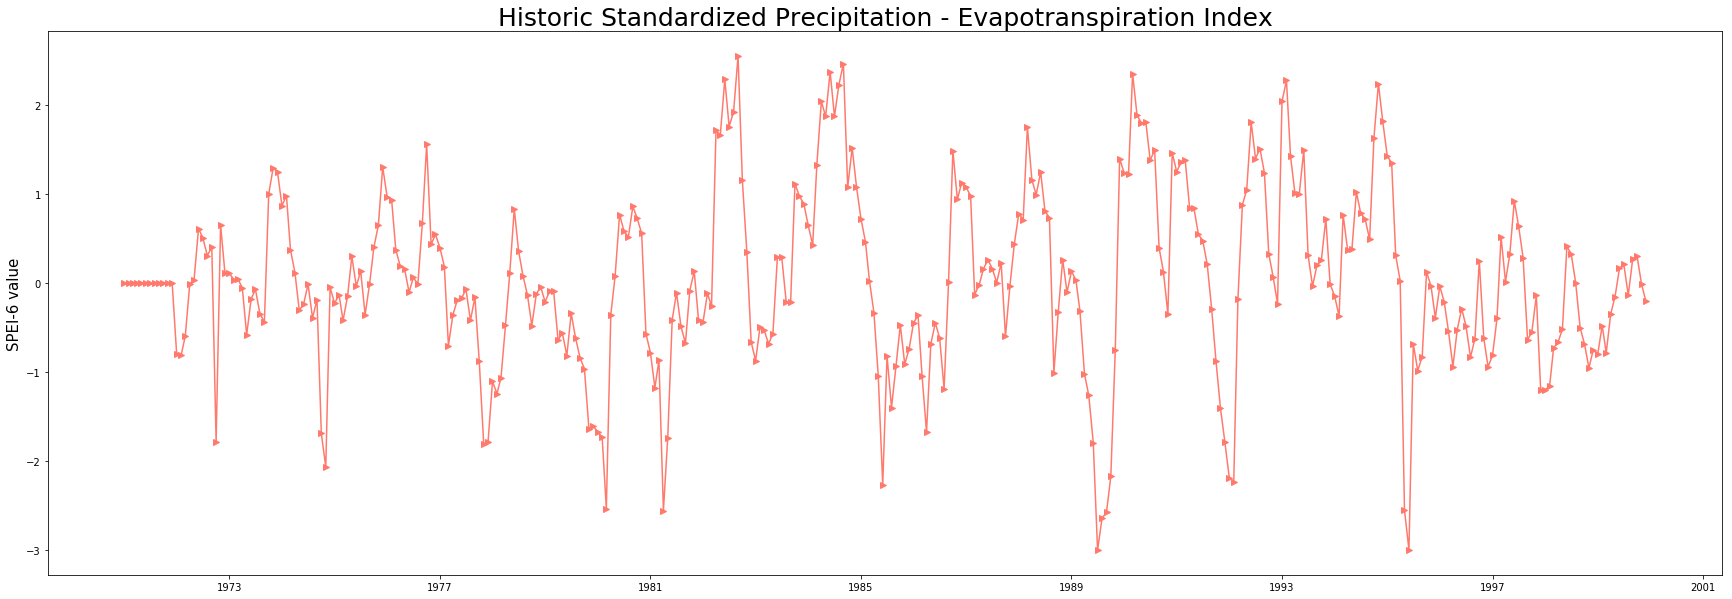

In [51]:
#Plot the calculated SPI values over time
fig = plt.figure(figsize=(30,10) )
plt.plot(dates[h_in:h_out],SPEI6,"->",color='#ff796c')
plt.ylabel('SPEI-6 value',size=15)
plt.title('Historic Standardized Precipitation - Evapotranspiration Index',size=25)
plt.show()

Exercise 9: SSFI-1 calculation for each month over the historic time-period 
==========

In [52]:
# Extract historic data
hist_dataseries = variables['discharge'][h_in:h_out]     

In [53]:
SSFI1 = np.zeros(hist_dataseries.shape)

In [54]:
# loop over all months to calculate SPI per month
for m in range(12):
    
    # Extract values per month, ignore first, incomplete year
    values = np.zeros(years_h-1)
    for yr in range(1,years_h):     
        values[yr-1] = hist_dataseries[(12*yr)+m]

    # Find distribution parameters of Gamma function      
    dist = getattr(stats, 'gamma')
    param = dist.fit(values)
    rv = dist(*param)   
    
    # Solve issue with zero values in Gamma distribution (cfr.Stagge et al. 2015)  
    nyears_zero = len(values) - np.count_nonzero(values)
    p_zero = nyears_zero / len(values)
    p_zero_mean = (nyears_zero + 1) / (2 * (len(values) + 1))           
    ppd = (values * 0 ) + p_zero_mean
    ppd[np.nonzero(values)] = p_zero+((1-p_zero)*rv.cdf(values[np.nonzero(values)]))
    
    # Standardize the cummulative distribution function
    z = stats.norm.ppf(ppd)                                   
    z[z>3] = 3
    z[z<-3] = -3 
    
    # Bring the SPI values back in their right spot in the time series
    for yr in range(1,years_h):
        SSFI1[(12*yr)+m] = z[yr-1]      

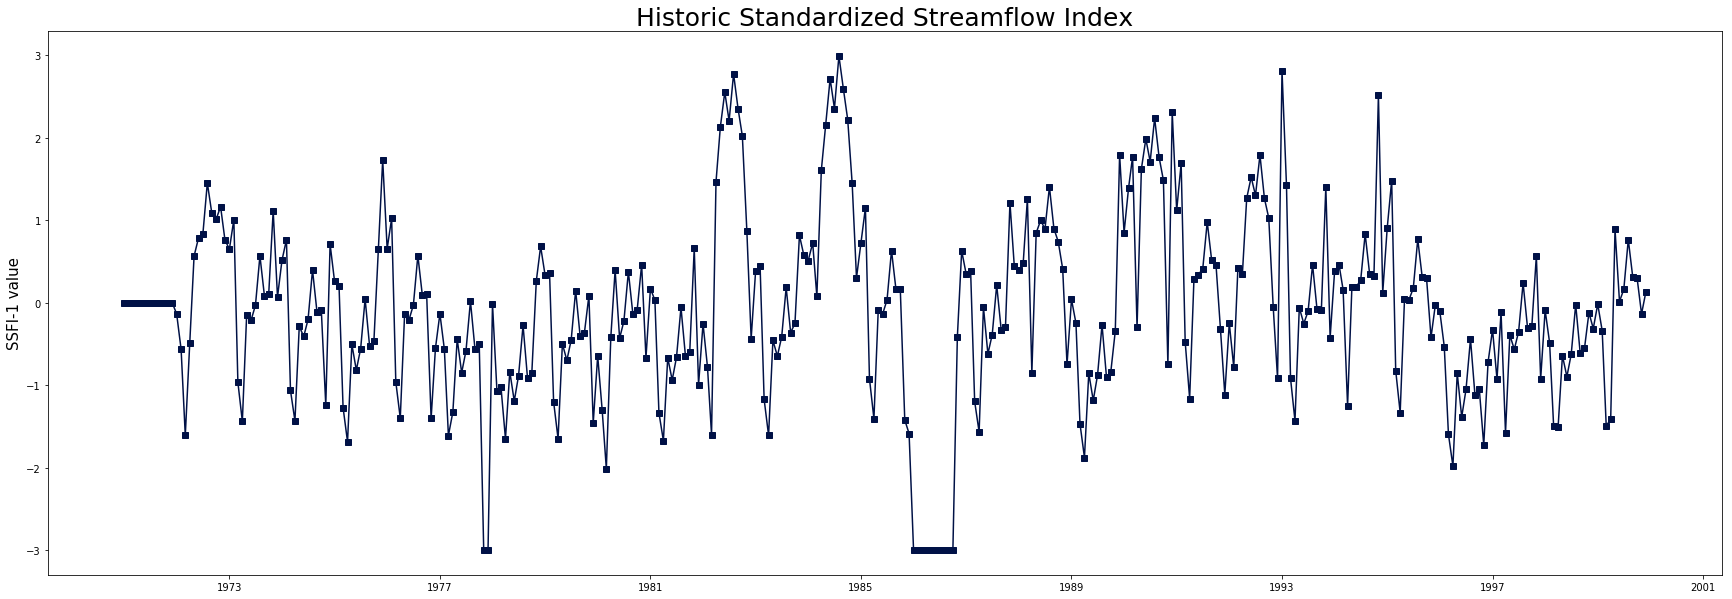

In [55]:
#Plot the calculated SPI values over time
fig = plt.figure(figsize=(30,10) )
plt.plot(dates[h_in:h_out],SSFI1,"-s",color='#001146')
plt.ylabel('SSFI-1 value',size=15)
plt.title('Historic Standardized Streamflow Index',size=25)
plt.show()

Exercise 10: SSFI-3 calculation for each month over the historic time-period 
==========

In [56]:
# Extract historic data
hist_dataseries = variables['discharge'][h_in:h_out]    

In [57]:
SSFI3 = np.zeros(hist_dataseries.shape)

In [58]:
# Create accumulated data
accumulationtime = 3   
cummuldata = np.cumsum(hist_dataseries, dtype=float)                 
cummuldata[accumulationtime:] = cummuldata[accumulationtime:] - cummuldata[:-accumulationtime]         
cummuldata[:accumulationtime - 1] = np.nan                                           
cummul_hist_dataseries = cummuldata  

In [59]:
# loop over all months to calculate SPI per month
for m in range(12):
    
    # Extract values per month, ignore first, incomplete year
    values = np.zeros(years_h-1)
    for yr in range(1,years_h):     
        values[yr-1] = cummul_hist_dataseries[(12*yr)+m]

    # Find distribution parameters of Gamma function      
    dist = getattr(stats, 'gamma')
    param = dist.fit(values)
    rv = dist(*param)   
    
    # Solve issue with zero values in Gamma distribution (cfr.Stagge et al. 2015)  
    nyears_zero = len(values) - np.count_nonzero(values)
    p_zero = nyears_zero / len(values)
    p_zero_mean = (nyears_zero + 1) / (2 * (len(values) + 1))           
    ppd = (values * 0 ) + p_zero_mean
    ppd[np.nonzero(values)] = p_zero+((1-p_zero)*rv.cdf(values[np.nonzero(values)]))
    
    # Standardize the cummulative distribution function
    z = stats.norm.ppf(ppd)                                   
    z[z>3] = 3
    z[z<-3] = -3 
    
    # Bring the SPI values back in their right spot in the time series
    for yr in range(1,years_h):
        SSFI3[(12*yr)+m] = z[yr-1]   

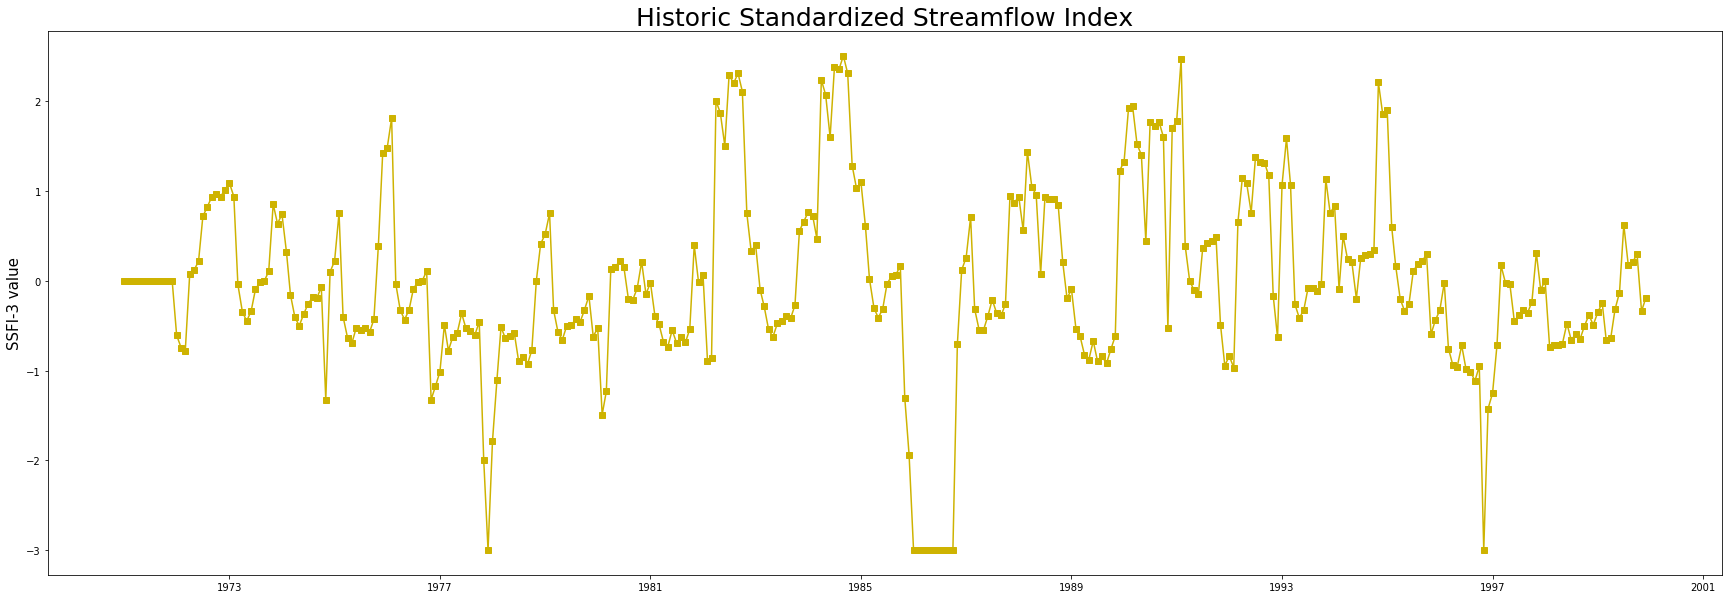

In [60]:
#Plot the calculated SPI values over time
fig = plt.figure(figsize=(30,10) )
plt.plot(dates[h_in:h_out],SSFI3,"-s",color='#ceb301')
plt.ylabel('SSFI-3 value',size=15)
plt.title('Historic Standardized Streamflow Index',size=25)
plt.show()

Exercise 11: SSFI-6 calculation for each month over the historic time-period 
==========

In [61]:
# Extract historic data
hist_dataseries = variables['discharge'][h_in:h_out]    

In [62]:
SSFI6 = np.zeros(hist_dataseries.shape)

In [63]:
# Create accumulated data
accumulationtime = 6   
cummuldata = np.cumsum(hist_dataseries, dtype=float)                 
cummuldata[accumulationtime:] = cummuldata[accumulationtime:] - cummuldata[:-accumulationtime]         
cummuldata[:accumulationtime - 1] = np.nan                                           
cummul_hist_dataseries = cummuldata  

In [64]:
# loop over all months to calculate SPI per month
for m in range(12):
    
    # Extract values per month, ignore first, incomplete year
    values = np.zeros(years_h-1)
    for yr in range(1,years_h):     
        values[yr-1] = cummul_hist_dataseries[(12*yr)+m]

    # Find distribution parameters of Gamma function      
    dist = getattr(stats, 'gamma')
    param = dist.fit(values)
    rv = dist(*param)   
    
    # Solve issue with zero values in Gamma distribution (cfr.Stagge et al. 2015)  
    nyears_zero = len(values) - np.count_nonzero(values)
    p_zero = nyears_zero / len(values)
    p_zero_mean = (nyears_zero + 1) / (2 * (len(values) + 1))           
    ppd = (values * 0 ) + p_zero_mean
    ppd[np.nonzero(values)] = p_zero+((1-p_zero)*rv.cdf(values[np.nonzero(values)]))
    
    # Standardize the cummulative distribution function
    z = stats.norm.ppf(ppd)                                   
    z[z>3] = 3
    z[z<-3] = -3 
    
    # Bring the SPI values back in their right spot in the time series
    for yr in range(1,years_h):
        SSFI6[(12*yr)+m] = z[yr-1]   

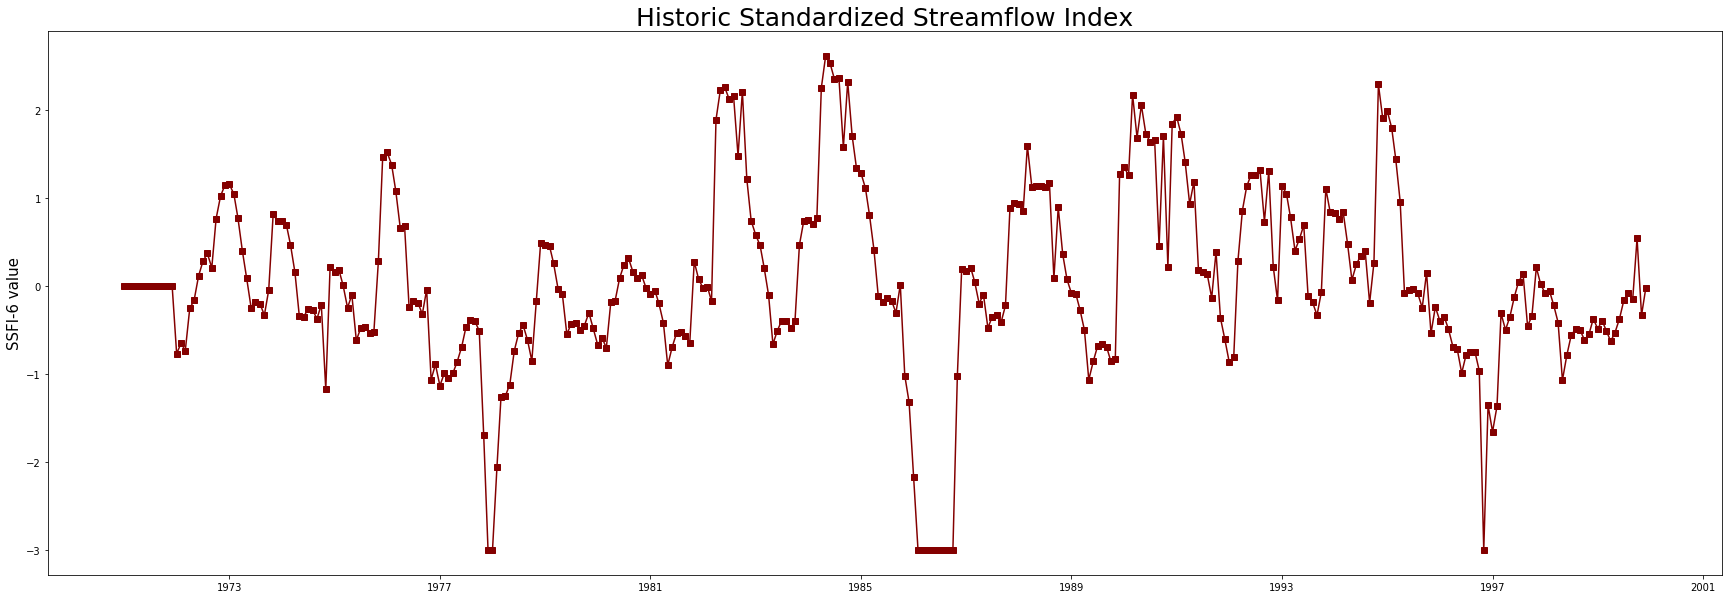

In [65]:
#Plot the calculated SPI values over time
fig = plt.figure(figsize=(30,10) )
plt.plot(dates[h_in:h_out],SSFI6,"-s",color='#840000')
plt.ylabel('SSFI-6 value',size=15)
plt.title('Historic Standardized Streamflow Index',size=25)
plt.show()

Exercise 12: Evaluate historic  drought conditions 
==========

In [66]:
# Define drought threshold over which droughts are being identified
threshold = -1 
thresholds = SPI1 * 0 + threshold

In [67]:
# Identify droughts
dSPI1 = np.zeros(SPI1.shape)
dSPI1[SPI1<-1] = 1
dSPI3 = np.zeros(SPI3.shape)
dSPI3[SPI3<-1] = 1
dSPI6 = np.zeros(SPI6.shape)
dSPI6[SPI6<-1] = 1
dSPEI1 = np.zeros(SPEI1.shape)
dSPEI1[SPEI1<-1] = 1
dSPEI3 = np.zeros(SPEI3.shape)
dSPEI3[SPEI3<-1] = 1
dSPEI6 = np.zeros(SPEI6.shape)
dSPEI6[SPEI6<-1] = 1
dSSFI1 = np.zeros(SSFI1.shape)
dSSFI1[SSFI1<-1] = 1
dSSFI3 = np.zeros(SSFI3.shape)
dSSFI3[SSFI3<-1] = 1
dSSFI6 = np.zeros(SSFI6.shape)
dSSFI6[SSFI6<-1] = 1

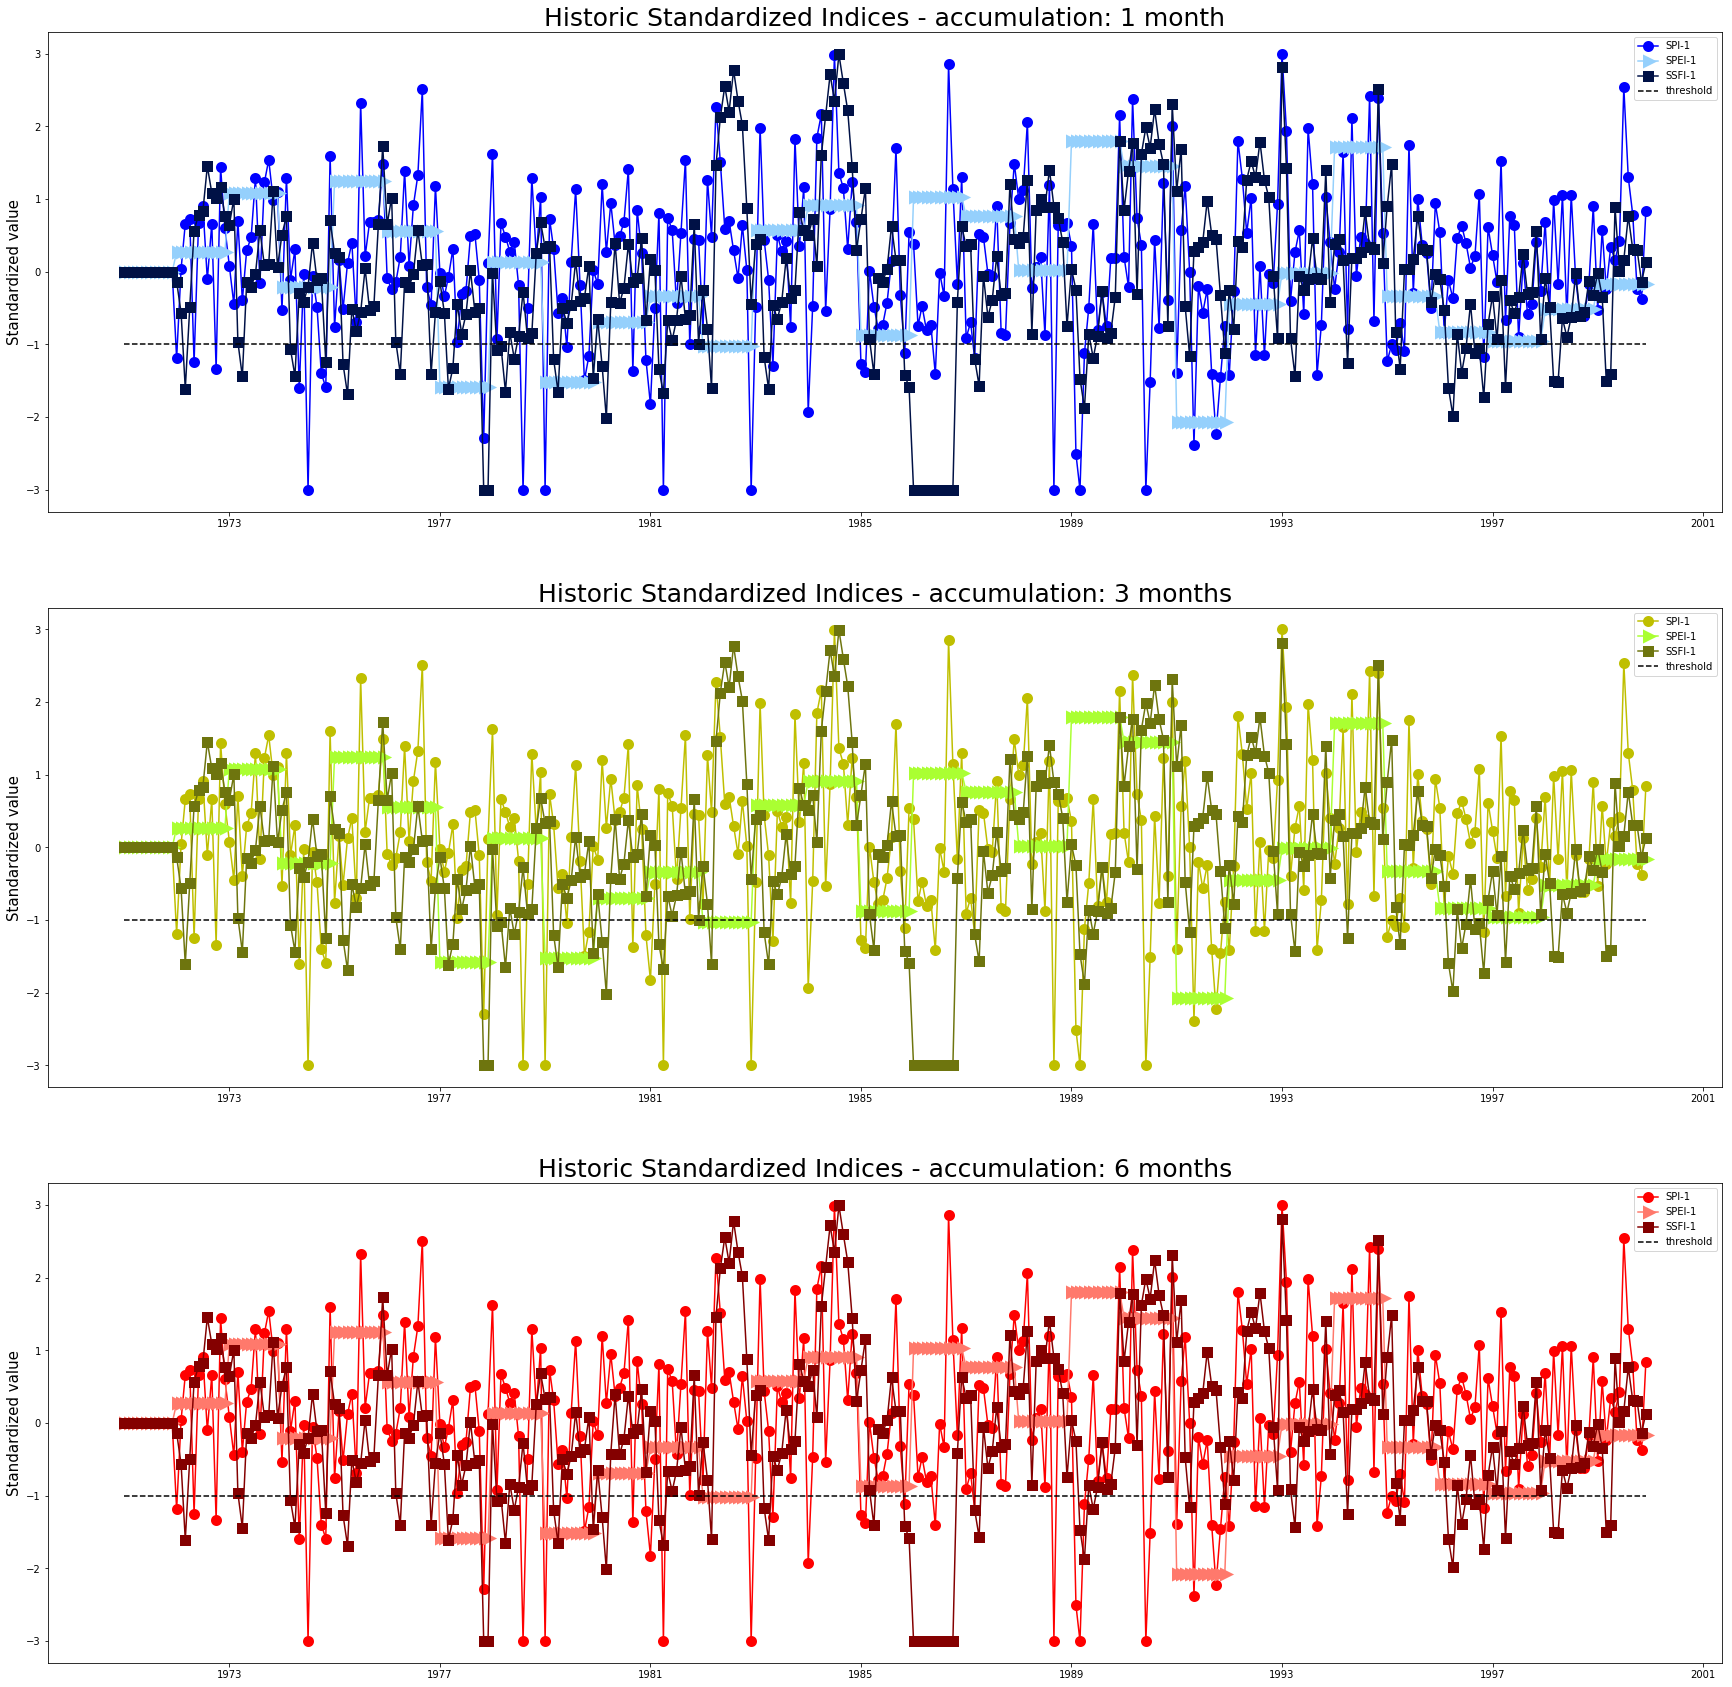

In [68]:
# Plot time-series of all indices and drought conditions
fig = plt.figure(figsize=(30,30) )

plt.subplot(3, 1, 1)
l1=plt.plot(dates[h_in:h_out],SPI1,"-o", color='b', mew=5, label='SPI-1')
l2=plt.plot(dates[h_in:h_out],SPEI1,"->", color='#95d0fc', mew=5, label='SPEI-1')
l3=plt.plot(dates[h_in:h_out],SSFI1,"-s", color='#001146', mew=5, label='SSFI-1')
l4=plt.plot(dates[h_in:h_out],thresholds,"--", color='k',label='threshold')
plt.ylabel('Standardized value',size=15)
plt.title('Historic Standardized Indices - accumulation: 1 month',size=25)
plt.legend()#(l1,l2,l3,l4), ('SPI-1', 'SPI-3', 'SPI-6','drought threshold'),'upper left')

plt.subplot(3, 1, 2)
l1=plt.plot(dates[h_in:h_out],SPI1,"-o", color='y', mew=5, label='SPI-1')
l2=plt.plot(dates[h_in:h_out],SPEI1,"->", color='#aaff32', mew=5, label='SPEI-1')
l3=plt.plot(dates[h_in:h_out],SSFI1,"-s", color='#6e750e', mew=5, label='SSFI-1')
l4=plt.plot(dates[h_in:h_out],thresholds,"--", color='k', mew=5, label='threshold')
plt.ylabel('Standardized value',size=15)
plt.title('Historic Standardized Indices - accumulation: 3 months',size=25)
plt.legend()#(l1,l2,l3,l4), ('SPI-1', 'SPI-3', 'SPI-6','drought threshold'),'upper left')

plt.subplot(3, 1, 3)
l1=plt.plot(dates[h_in:h_out],SPI1,"-o", color='r', mew=5, label='SPI-1')
l2=plt.plot(dates[h_in:h_out],SPEI1,"->", color='#ff796c', mew=5, label='SPEI-1')
l3=plt.plot(dates[h_in:h_out],SSFI1,"-s", color='#840000', mew=5, label='SSFI-1')
l4=plt.plot(dates[h_in:h_out],thresholds,"--", color='k',label='threshold')
plt.ylabel('Standardized value',size=15)
plt.title('Historic Standardized Indices - accumulation: 6 months',size=25)
plt.legend()#(l1,l2,l3,l4), ('SPI-1', 'SPI-3', 'SPI-6','drought threshold'),'upper left')


plt.show()

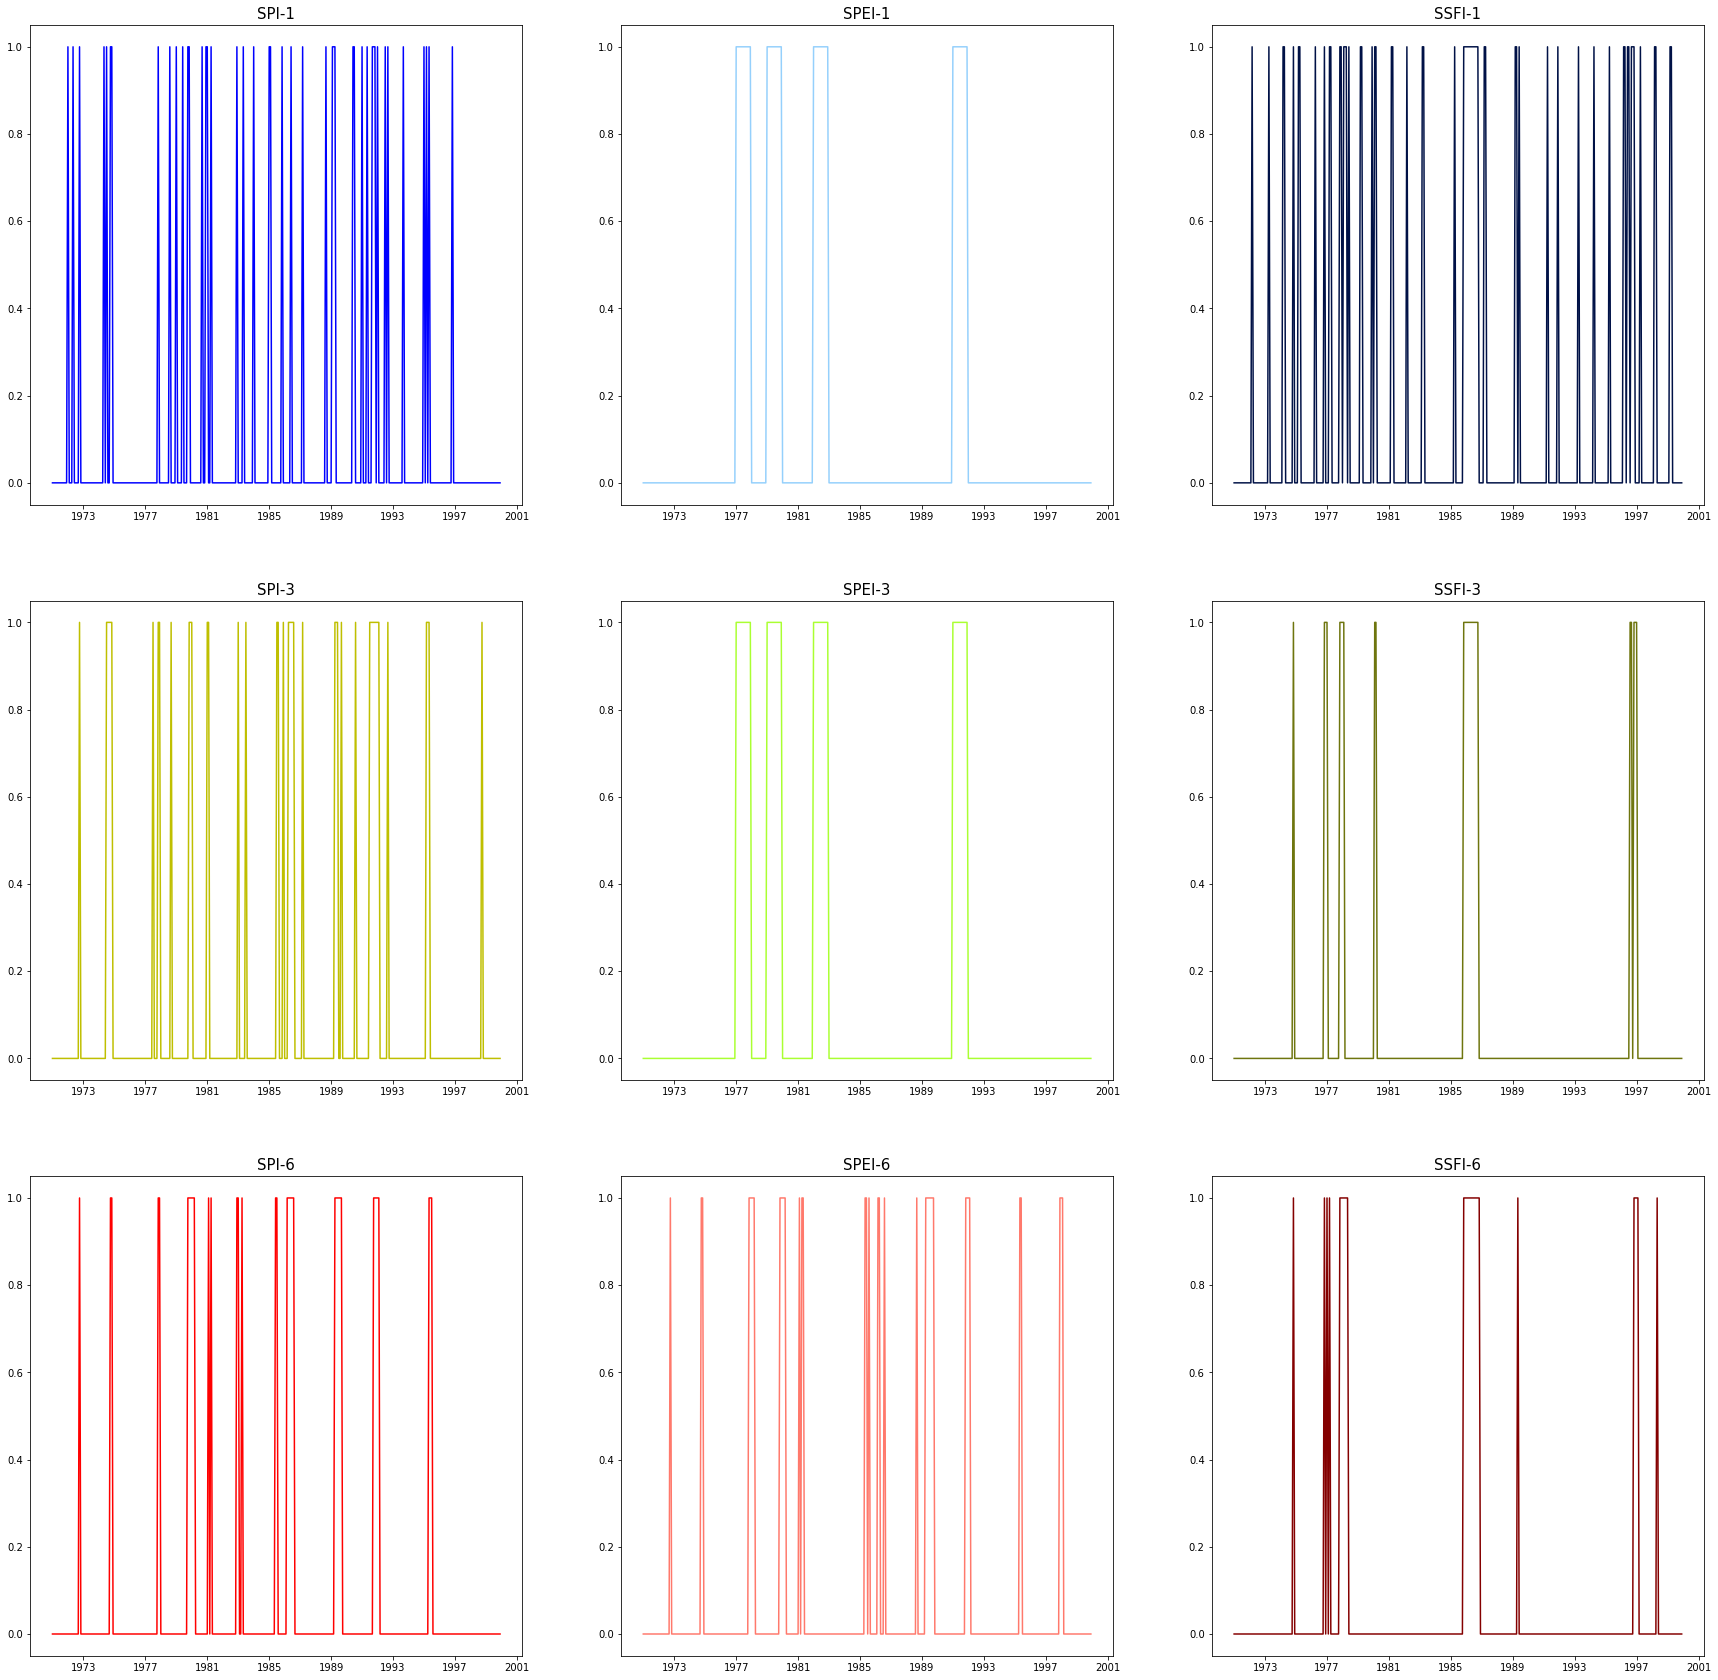

In [69]:
# Plot drought conditions of all indices and


fig = plt.figure(figsize=(30,30) )

plt.subplot(3, 3, 1)
l1=plt.plot(dates[h_in:h_out],dSPI1,"-", color='b', mew=5, label='SPI-1')
plt.title('SPI-1',size=15)
plt.subplot(3, 3, 2)
l2=plt.plot(dates[h_in:h_out],dSPEI1,"-", color='#95d0fc', mew=5, label='SPEI-1')
plt.title('SPEI-1',size=15)
plt.subplot(3, 3, 3)
l3=plt.plot(dates[h_in:h_out],dSSFI1,"-", color='#001146', mew=5, label='SSFI-1')
plt.title('SSFI-1',size=15)

plt.subplot(3, 3, 4)
l1=plt.plot(dates[h_in:h_out],dSPI3,"-", color='y', mew=5, label='SPI-3')
plt.title('SPI-3',size=15)
plt.subplot(3, 3, 5)
l2=plt.plot(dates[h_in:h_out],dSPEI3,"-", color='#aaff32', mew=5, label='SPEI-3')
plt.title('SPEI-3',size=15)
plt.subplot(3, 3, 6)
l3=plt.plot(dates[h_in:h_out],dSSFI3,"-", color='#6e750e', mew=5, label='SSFI-3')
plt.title('SSFI-3',size=15)

plt.subplot(3, 3, 7)
l1=plt.plot(dates[h_in:h_out],dSPI6,"-", color='r', mew=5, label='SPI-6')
plt.title('SPI-6',size=15)
plt.subplot(3, 3, 8)
l2=plt.plot(dates[h_in:h_out],dSPEI6,"-", color='#ff796c', mew=5, label='SPEI-6')
plt.title('SPEI-6',size=15)
plt.subplot(3, 3, 9)
l3=plt.plot(dates[h_in:h_out],dSSFI6,"-", color='#840000', mew=5, label='SSFI-6')
plt.title('SSFI-6',size=15)

plt.show()

Exercise 13: Drought thresholds
==

In [70]:
# Fixed drought threshold
Pthresholdf  = np.nanpercentile(variables['precipitation'][h_in:h_out],10)
PEthresholdf = np.nanpercentile((variables['precipitation'][h_in:h_out]-variables['evapotranspiration'][h_in:h_out])*-1,90)*-1
Qthresholdf = np.nanpercentile(variables['discharge'][h_in:h_out],10)

dPf= np.zeros(variables['precipitation'][h_in:h_out].shape)
dPf[variables['precipitation'][h_in:h_out]<Pthresholdf] = 1
dPEf= np.zeros(variables['evapotranspiration'][h_in:h_out].shape)
dPEf[(variables['precipitation'][h_in:h_out]-variables['evapotranspiration'][h_in:h_out])<PEthresholdf] = 1
dQf= np.zeros(variables['discharge'][h_in:h_out].shape)
dQf[variables['discharge'][h_in:h_out]<Qthresholdf] = 1

In [71]:
# Variable drought threshold

dPv= np.zeros(variables['precipitation'][h_in:h_out].shape)
dPEv= np.zeros(variables['evapotranspiration'][h_in:h_out].shape)
dQv= np.zeros(variables['discharge'][h_in:h_out].shape)

Pthresholdv  = np.zeros(12)
PEthresholdv = np.zeros(12)
Qthresholdv = np.zeros(12)
    
for m in range(12):
    
    # Extract values per month, then calculate threshold, then check when under threshold
    pt = np.zeros(years_h)
    pet = np.zeros(years_h)
    qt = np.zeros(years_h)
    for yr in range(years_h):     
        pt[yr] = variables['precipitation'][h_in:h_out][(12*yr)+m]
        pet[yr] = variables['precipitation'][h_in:h_out][(12*yr)+m]-variables['evapotranspiration'][h_in:h_out][(12*yr)+m]
        qt[yr] = variables['discharge'][h_in:h_out][(12*yr)+m]
    Pthresholdv[m]  = np.nanpercentile(pt,10)
    PEthresholdv[m] = np.nanpercentile(pet*-1,90)*-1
    Qthresholdv[m] = np.nanpercentile(qt,10) 
    
    for yr in range(years_h):
        if pt[yr] < Pthresholdv[m]:
            dPv[(12*yr)+m] = 1  
        if pet[yr] < PEthresholdv[m]:
            dPEv[(12*yr)+m] = 1  
        if qt[yr] < Qthresholdv[m]:
            dQv[(12*yr)+m] = 1      

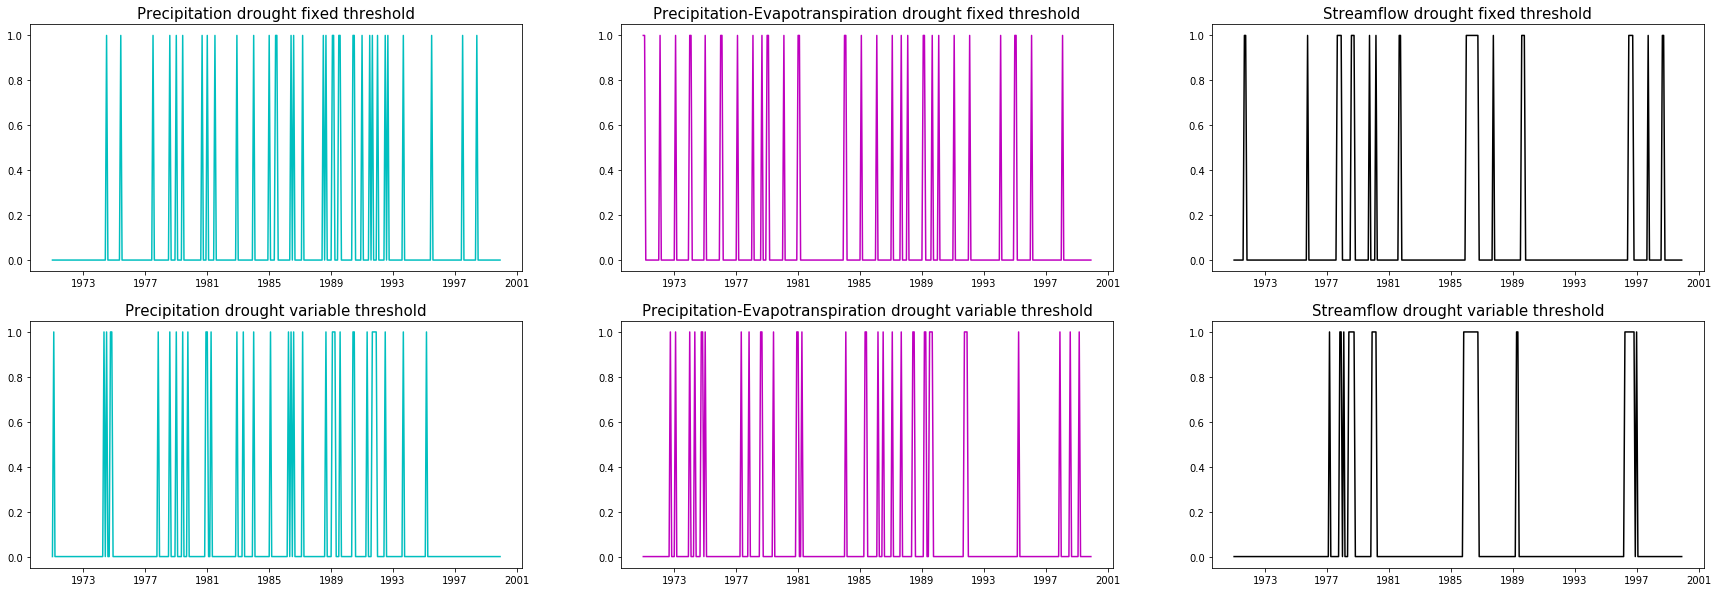

In [72]:
# Plot drought conditions under fixed and flexible conditions

fig = plt.figure(figsize=(30,10) )

plt.subplot(2, 3, 1)
l1=plt.plot(dates[h_in:h_out],dPf,"-", color='c', mew=5)
plt.title('Precipitation drought fixed threshold',size=15)
plt.subplot(2, 3, 4)
l2=plt.plot(dates[h_in:h_out],dPv,"-", color='c', mew=5)
plt.title('Precipitation drought variable threshold',size=15)


plt.subplot(2, 3, 2)
l1=plt.plot(dates[h_in:h_out],dPEf,"-", color='m', mew=5)
plt.title('Precipitation-Evapotranspiration drought fixed threshold',size=15)
plt.subplot(2, 3, 5)
l2=plt.plot(dates[h_in:h_out],dPEv,"-", color='m')
plt.title('Precipitation-Evapotranspiration drought variable threshold',size=15)

plt.subplot(2, 3, 3)
l1=plt.plot(dates[h_in:h_out],dQf,"-", color='k', mew=5)
plt.title('Streamflow drought fixed threshold',size=15)
plt.subplot(2, 3, 6)
l2=plt.plot(dates[h_in:h_out],dQv,"-", color='k', mew=5)
plt.title('Streamflow drought variable threshold',size=15)

plt.show()

In [73]:
# Analyse the total number of drought months
print('fixed threshold')
print('number of months under historic Pr drought conditions: ',np.sum(dPf))
print('number of months under historic Pr-Evt drought conditions: ',np.sum(dPEf))
print('number of months under historic Q drought conditions: ',np.sum(dQf))
print('variable threshold')
print('number of months under historic Pr drought conditions: ',np.sum(dPv))
print('number of months under historic Pr-Evt drought conditions: ',np.sum(dPEv))
print('number of months under historic Q drought conditions: ',np.sum(dQv))

fixed threshold
number of months under historic Pr drought conditions:  35.0
number of months under historic Pr-Evt drought conditions:  35.0
number of months under historic Q drought conditions:  35.0
variable threshold
number of months under historic Pr drought conditions:  36.0
number of months under historic Pr-Evt drought conditions:  36.0
number of months under historic Q drought conditions:  36.0


In [74]:
# analyse the propagation of droughts over time to evaluate drought duration
dPfpropagation = dPf * 0
dPvpropagation = dPf * 0
for t in range(len(dPf)):
    if dPf[t] == 1:
        dPfpropagation[t] = dPfpropagation[t-1] + 1
        dPfpropagation[t-1] = 0
    else:
        dPfpropagation[t] = 0
    if dPv[t] == 1:
        dPvpropagation[t] = dPvpropagation[t-1] + 1
        dPvpropagation[t-1] = 0
    else:
        dPvpropagation[t] = 0
print('historic average duration fixed threshold Pr drought conditions: ',np.mean(dPfpropagation[dPfpropagation>0]),' months')
print('historic average duration variable threshold Pr  drought conditions: ',np.mean(dPvpropagation[dPvpropagation>0]),' months')

dPEfpropagation = dPEf * 0
dPEvpropagation = dPEf * 0
for t in range(len(dPf)):
    if dPEf[t] == 1:
        dPEfpropagation[t] = dPEfpropagation[t-1] + 1
        dPEfpropagation[t-1] = 0
    else:
        dPEfpropagation[t] = 0
    if dPEv[t] == 1:
        dPEvpropagation[t] = dPEvpropagation[t-1] + 1
        dPEvpropagation[t-1] = 0
    else:
        dPEvpropagation[t] = 0
print('historic average duration fixed threshold Pr-Evt drought conditions: ',np.mean(dPEfpropagation[dPfpropagation>0]),' months')
print('historic average duration variable threshold Pr-Evt drought conditions: ',np.mean(dPEvpropagation[dPvpropagation>0]),' months')

dQfpropagation = dQf * 0
dQvpropagation = dQf * 0
for t in range(len(dQf)):
    if dQf[t] == 1:
        dQfpropagation[t] = dQfpropagation[t-1] + 1
        dQfpropagation[t-1] = 0
    else:
        dQfpropagation[t] = 0
    if dQv[t] == 1:
        dQvpropagation[t] = dQvpropagation[t-1] + 1
        dQvpropagation[t-1] = 0
    else:
        dQvpropagation[t] = 0
print('historic average duration fixed threshold Q drought conditions: ',np.mean(dQfpropagation[dQfpropagation>0]),' months')
print('historic average duration variable threshold Q drought conditions: ',np.mean(dQvpropagation[dQvpropagation>0]),' months')


historic average duration fixed threshold Pr drought conditions:  1.1290322580645162  months
historic average duration variable threshold Pr  drought conditions:  1.2857142857142858  months
historic average duration fixed threshold Pr-Evt drought conditions:  0.06451612903225806  months
historic average duration variable threshold Pr-Evt drought conditions:  0.4642857142857143  months
historic average duration fixed threshold Q drought conditions:  2.6923076923076925  months
historic average duration variable threshold Q drought conditions:  4.0  months


In [75]:
# Analyse the total number of drought events
dPfpropagation[dPfpropagation>0] = 1
print('historic number of Pr droughts - fixed threshold: ',np.sum(dPfpropagation))
dPEfpropagation[dPEfpropagation>0] = 1
print('historic number of Pr-Evt droughts - fixed threshold: ',np.sum(dPEfpropagation))
dQfpropagation[dQfpropagation>0] = 1
print('historic number of Q droughts - fixed threshold: ',np.sum(dQfpropagation))

dPvpropagation[dPvpropagation>0] = 1
print('historic number of Pr droughts - variable threshold: ',np.sum(dPvpropagation))
dPEvpropagation[dPEvpropagation>0] = 1
print('historic number of Pr-Evt droughts - variable threshold: ',np.sum(dPEvpropagation))
dQvpropagation[dQvpropagation>0] = 1
print('historic number of Q droughts - variable threshold: ',np.sum(dQvpropagation))

historic number of Pr droughts - fixed threshold:  31.0
historic number of Pr-Evt droughts - fixed threshold:  27.0
historic number of Q droughts - fixed threshold:  13.0
historic number of Pr droughts - variable threshold:  28.0
historic number of Pr-Evt droughts - variable threshold:  26.0
historic number of Q droughts - variable threshold:  9.0


Exercise 14: Future drought conditions
    ==

In [82]:
# Identify future droughts
future_dPf= np.zeros(variables['precipitation'][f_in:f_out].shape)
future_dPf[variables['precipitation'][f_in:f_out]<Pthresholdf] = 1
future_dPEf= np.zeros(variables['evapotranspiration'][f_in:f_out].shape)
future_dPEf[(variables['precipitation'][f_in:f_out]-variables['evapotranspiration'][f_in:f_out])<PEthresholdf] = 1
future_dQf= np.zeros(variables['discharge'][f_in:f_out].shape)
future_dQf[variables['discharge'][f_in:f_out]<Qthresholdf] = 1


In [84]:
# Variable drought threshold

future_dPv= np.zeros(variables['precipitation'][f_in:f_out].shape)
future_dPEv= np.zeros(variables['evapotranspiration'][f_in:f_out].shape)
future_dQv= np.zeros(variables['discharge'][f_in:f_out].shape)
    
for m in range(12):
    
    # Extract values per month, then calculate threshold, then check when under threshold
    pt = np.zeros(years_f)
    pet = np.zeros(years_f)
    qt = np.zeros(years_f)
    for yr in range(years_f):     
        pt[yr] = variables['precipitation'][f_in:f_out][(12*yr)+m]
        pet[yr] = variables['precipitation'][f_in:f_out][(12*yr)+m]-variables['evapotranspiration'][f_in:f_out][(12*yr)+m]
        qt[yr] = variables['discharge'][f_in:f_out][(12*yr)+m]
  
    for yr in range(years_h):
        if pt[yr] < Pthresholdv[m]:
            future_dPv[(12*yr)+m] = 1  
        if pet[yr] < PEthresholdv[m]:
            future_dPEv[(12*yr)+m] = 1  
        if qt[yr] < Qthresholdv[m]:
            future_dQv[(12*yr)+m] = 1      

In [85]:
# Analyse the total number of drought months
print('fixed threshold')
print('number of months under future Pr drought conditions: ',np.sum(future_dPf))
print('number of months under future Pr-Evt drought conditions: ',np.sum(future_dPEf))
print('number of months under future Q drought conditions: ',np.sum(future_dQf))
print('variable threshold')
print('number of months under future Pr drought conditions: ',np.sum(future_dPv))
print('number of months under future Pr-Evt drought conditions: ',np.sum(future_dPEv))
print('number of months under future Q drought conditions: ',np.sum(future_dQv))

fixed threshold
number of months under future Pr drought conditions:  66.0
number of months under future Pr-Evt drought conditions:  66.0
number of months under future Q drought conditions:  71.0
variable threshold
number of months under future Pr drought conditions:  36.0
number of months under future Pr-Evt drought conditions:  36.0
number of months under future Q drought conditions:  36.0


In [88]:
# analyse the propagation of droughts over time to evaluate drought duration
future_dPfpropagation = future_dPf * 0
future_dPvpropagation = future_dPf * 0
for t in range(len(future_dPf)):
    if future_dPf[t] == 1:
        future_dPfpropagation[t] = future_dPfpropagation[t-1] + 1
        future_dPfpropagation[t-1] = 0
    else:
        future_dPfpropagation[t] = 0
    if future_dPv[t] == 1:
        future_dPvpropagation[t] = future_dPvpropagation[t-1] + 1
        future_dPvpropagation[t-1] = 0
    else:
        future_dPvpropagation[t] = 0
print('future average duration fixed threshold Pr drought conditions: ',np.mean(future_dPfpropagation[future_dPfpropagation>0]),' months')
print('future average duration variable threshold Pr  drought conditions: ',np.mean(future_dPvpropagation[future_dPvpropagation>0]),' months')

future_dPEfpropagation = future_dPEf * 0
future_dPEvpropagation = future_dPEf * 0
for t in range(len(future_dPf)):
    if future_dPEf[t] == 1:
        future_dPEfpropagation[t] = future_dPEfpropagation[t-1] + 1
        future_dPEfpropagation[t-1] = 0
    else:
        future_dPEfpropagation[t] = 0
    if future_dPEv[t] == 1:
        future_dPEvpropagation[t] = future_dPEvpropagation[t-1] + 1
        future_dPEvpropagation[t-1] = 0
    else:
        future_dPEvpropagation[t] = 0
print('future average duration fixed threshold Pr-Evt drought conditions: ',np.mean(future_dPEfpropagation[future_dPfpropagation>0]),' months')
print('future average duration variable threshold Pr-Evt drought conditions: ',np.mean(future_dPEvpropagation[future_dPvpropagation>0]),' months')

future_dQfpropagation = future_dQf * 0
future_dQvpropagation = future_dQf * 0
for t in range(len(future_dQf)):
    if future_dQf[t] == 1:
        future_dQfpropagation[t] = future_dQfpropagation[t-1] + 1
        future_dQfpropagation[t-1] = 0
    else:
        future_dQfpropagation[t] = 0
    if future_dQv[t] == 1:
        future_dQvpropagation[t] = future_dQvpropagation[t-1] + 1
        future_dQvpropagation[t-1] = 0
    else:
        future_dQvpropagation[t] = 0
print('future average duration fixed threshold Q drought conditions: ',np.mean(future_dQfpropagation[future_dQfpropagation>0]),' months')
print('future average duration variable threshold Q drought conditions: ',np.mean(future_dQvpropagation[future_dQvpropagation>0]),' months')


future average duration fixed threshold Pr drought conditions:  1.1379310344827587  months
future average duration variable threshold Pr  drought conditions:  1.2857142857142858  months
future average duration fixed threshold Pr-Evt drought conditions:  0.1206896551724138  months
future average duration variable threshold Pr-Evt drought conditions:  0.4642857142857143  months
future average duration fixed threshold Q drought conditions:  3.0869565217391304  months
future average duration variable threshold Q drought conditions:  4.0  months
